In [1]:
# Recombination

# Objective: Convert 
    # from raw-like tables in cabi.db
    # to a dataframe with counts of pickups/dropoffs 
        # binned by hour and by station
            # 50M bins (~600 stations * 90000 hours of data)
    # also we will want to quantify opportunity!

# num_rides actually < num_bins

# num_rides = 28M total, and that includes some electrics
    # average # rides /station/hour is 0.5
        # but this undercounts b/c a lot of these stations are much newer than 2010
        # plus the busiest stations are the ones of primary interest here !

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import time
import datetime
import io
import requests
import json

date_format_standard = '%Y-%m-%d %H:%M:%S'

In [3]:
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [4]:
import tensorflow as tf
from tensorflow import keras

In [5]:
tf.__version__

'2.1.0'

In [6]:
pd.options.display.max_rows=2000
pd.options.display.max_columns=50

In [7]:
# Jumping ahead:

# Goal: store all the data in four 2-D arrays:

# bikes: num_hours * num_stations
# docks: num_hours * num_stations
# weather: num_hours * 4   (temperature, precip, avg wind speed, snow depth)
# dt: num_hours * 4        (year, dayofyear, dayofweek, hour)

In [8]:
num_timebins = 365*24*10 + 72 + 24*102 + 13
print(num_timebins)
# total number of time slots 

90133


In [9]:
# Preset 90133*4 array with calendar/clock values:

In [10]:
def is_leap_year(arr):
    return(~((arr%4).astype(bool) | ((~(arr%100).astype(bool))&((arr%400).astype(bool)))))
cut_year=2021   
    
num_rows=num_timebins   # 90133 hours of system operation through end of 2020

ydhw = np.zeros((num_rows,4),dtype=np.uint32)
dt000 = datetime.datetime(2010,9,20,11)
cur = [dt000.year,\
           dt000.timetuple().tm_yday,\
           dt000.hour,dt000.weekday()]
j=0

empty_PS = pd.Series(dtype='int64')
d_ydh2timeidx = {}

tic=time.time()
while (cur[0]<cut_year):
    ydhw[j] = cur
    ydh_tuple = tuple(ydhw[j][:3])
    d_ydh2timeidx[ydh_tuple]=j
    
    
    # increment to next hour:
    j+=1
    cur[2] += 1 # hour
    if (cur[2]==24):
        cur[2] = 0
        cur[3] = (1+cur[3])%7 # dayofweek
        cur[1] += 1 # dayofyear
        if (cur[1] > (365+is_leap_year(np.array(cur[0])))):
            # Jan 1 of new year:
            cur[1]=1
            cur[0]+=1
ydhw=ydhw[:j]
# # # # # ydhw[(is_leap_year(ydhw[:,0]))&(ydhw[:,1]>=60),1] -= 1  # shift for leap year (Feb 29 = Feb 28)
print(time.time()-tic)
print()
print(ydhw)

0.4030005931854248

[[2010  263   11    0]
 [2010  263   12    0]
 [2010  263   13    0]
 ...
 [2020  366   21    3]
 [2020  366   22    3]
 [2020  366   23    3]]


# Data Inspection

In [11]:
# First read station info GBFS:

url_station_info = 'https://gbfs.capitalbikeshare.com/gbfs/en/station_information.json'
sta_info = pd.DataFrame(json.loads(requests.get(url_station_info).content)['data']['stations'])
sta_info.head()

capacity short_name                                          name  \
0        15      31000                           Eads St & 15th St S   
1        11      31001                           18th St & S Eads St   
2        17      31002                        Crystal Dr & 20th St S   
3        16      31003                        Crystal Dr & 15th St S   
4        11      31004  Aurora Hills Cmty Ctr / 18th St & S Hayes St   

   has_kiosk station_type eightd_station_services  \
0       True      classic                      []   
1       True      classic                      []   
2       True      classic                      []   
3       True      classic                      []   
4       True      classic                      []   

                                         rental_uris     rental_methods  \
0  {'ios': 'https://dc.lft.to/lastmile_qr_scan', ...  [KEY, CREDITCARD]   
1  {'ios': 'https://dc.lft.to/lastmile_qr_scan', ...  [KEY, CREDITCARD]   
2  {'ios': 'https://dc.lft.to/lastmile_qr_scan', ...  [KEY, CREDITCARD]   
3  {'ios': 'https://dc.lft.to/lastmile_qr_scan', ...  [KEY, CREDITCARD]   
4  {'ios': 'https://dc.lft.to/lastmile_qr_scan', ...  [KEY, CREDITCARD]   

  legacy_id        lon  eightd_has_key_dispenser  \
0         1 -77.053230                     False   
1         2 -77.053320                     False   
2         3 -77.049232                     False   
3         4 -77.049417                     False   
4         5 -77.059490                     False   

                            external_id station_id region_id        lat  \
0  082469cc-1f3f-11e7-bf6b-3863bb334450          1        41  38.858971   
1  08246b69-1f3f-11e7-bf6b-3863bb334450          2        41  38.857250   
2  08246c35-1f3f-11e7-bf6b-3863bb334450          3        41  38.856425   
3  08246cd5-1f3f-11e7-bf6b-3863bb334450          4        41  38.861056   
4  08246d68-1f3f-11e7-bf6b-3863bb334450          5        41  38.857866   

   electric_bike_surcharge_waiver  
0                           False  
1                           False  
2                           False  
3                           False  
4                           False

In [12]:
# Three different fields containing station identifiers!
    # station_id, legacy_id, short_name

# legacy_id same as station_id 
    
# Type conversion for both identifier schemes:
sta_info.station_id = sta_info.station_id.astype(int)
sta_info.short_name = sta_info.short_name.astype(int)

In [13]:
sta_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 622 entries, 0 to 621
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   capacity                        622 non-null    int64  
 1   short_name                      622 non-null    int32  
 2   name                            622 non-null    object 
 3   has_kiosk                       622 non-null    bool   
 4   station_type                    622 non-null    object 
 5   eightd_station_services         622 non-null    object 
 6   rental_uris                     622 non-null    object 
 7   rental_methods                  622 non-null    object 
 8   legacy_id                       622 non-null    object 
 9   lon                             622 non-null    float64
 10  eightd_has_key_dispenser        622 non-null    bool   
 11  external_id                     622 non-null    object 
 12  station_id                      622 

In [14]:
def get_tables(db):
    table_names=[]
    conn = sqlite3.connect(db)
    try:
        cursor = conn.cursor()
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
        tables = cursor.fetchall()
        table_names = [ttt[0] for ttt in tables]
        conn.close()
    except:
        conn.close()
    return(table_names)

In [15]:
db = 'cabi.db'
tables = get_tables(db)
print(tables)

['weather', 'past_outages', 'current_outages', 'holidays', 'trip_history']


In [16]:
j=0
tic=time.time()
while j<60000000:
    j+=1
print(time.time()-tic)
# it takes several seconds to count to 60M.
# So, many of our cells will take a while to run.

7.12399697303772


In [17]:
# Read all trip_history (8 minutes)
# We will process this down to a more manageable DF
table_name='trip_history'
tic=time.time()
conn = sqlite3.connect('cabi.db')
query = 'select * from '+table_name
df_th = pd.read_sql_query(query,conn)
conn.close()
print(time.time()-tic)
print(df_th.shape)
print(df_th.columns)

488.3193299770355
(28275446, 23)
Index(['mixed_start_datetime', 'duration', 'start_date', 'end_date',
       'start_station_number', 'start_station', 'end_station_number',
       'end_station', 'bike_number', 'member_type', 'ride_id', 'rideable_type',
       'started_at', 'ended_at', 'start_station_name', 'start_station_id',
       'end_station_name', 'end_station_id', 'start_lat', 'start_lng',
       'end_lat', 'end_lng', 'member_casual'],
      dtype='object')


In [18]:
tic=time.time()
conn = sqlite3.connect('cabi.db')
df_po = pd.read_sql_query('select * from past_outages',conn)
df_co = pd.read_sql_query('select * from current_outages',conn)
df_weather = pd.read_sql_query('select * from weather',conn)
df_holidays = pd.read_sql_query('select * from holidays',conn)
conn.close()
print(time.time()-tic)

20.120721578598022


In [19]:
df_th.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28275446 entries, 0 to 28275445
Data columns (total 23 columns):
 #   Column                Dtype  
---  ------                -----  
 0   mixed_start_datetime  object 
 1   duration              float64
 2   start_date            object 
 3   end_date              object 
 4   start_station_number  float64
 5   start_station         object 
 6   end_station_number    float64
 7   end_station           object 
 8   bike_number           object 
 9   member_type           object 
 10  ride_id               object 
 11  rideable_type         object 
 12  started_at            object 
 13  ended_at              object 
 14  start_station_name    object 
 15  start_station_id      float64
 16  end_station_name      object 
 17  end_station_id        float64
 18  start_lat             float64
 19  start_lng             float64
 20  end_lat               float64
 21  end_lng               float64
 22  member_casual         object 
dtypes: fl

In [20]:
df_th.shape

(28275446, 23)

In [21]:
df_th.head()

mixed_start_datetime  duration           start_date             end_date  \
0  2010-09-20 11:27:04    1012.0  2010-09-20 11:27:04  2010-09-20 11:43:56   
1  2010-09-20 11:41:22      61.0  2010-09-20 11:41:22  2010-09-20 11:42:23   
2  2010-09-20 12:05:37    2690.0  2010-09-20 12:05:37  2010-09-20 12:50:27   
3  2010-09-20 12:06:05    1406.0  2010-09-20 12:06:05  2010-09-20 12:29:32   
4  2010-09-20 12:10:43    1413.0  2010-09-20 12:10:43  2010-09-20 12:34:17   

   start_station_number                  start_station  end_station_number  \
0               31208.0       M St & New Jersey Ave SE             31108.0   
1               31209.0                 1st & N St  SE             31209.0   
2               31600.0                  5th & K St NW             31100.0   
3               31600.0                  5th & K St NW             31602.0   
4               31100.0  19th St & Pennsylvania Ave NW             31201.0   

                     end_station bike_number member_type ride_id  \
0                  4th & M St SW      W00742      Member    None   
1                 1st & N St  SE      W00032      Member    None   
2  19th St & Pennsylvania Ave NW      W00993      Member    None   
3        Park Rd & Holmead Pl NW      W00344      Member    None   
4                 15th & P St NW      W00883      Member    None   

  rideable_type started_at ended_at start_station_name  start_station_id  \
0          None       None     None               None               NaN   
1          None       None     None               None               NaN   
2          None       None     None               None               NaN   
3          None       None     None               None               NaN   
4          None       None     None               None               NaN   

  end_station_name  end_station_id  start_lat  start_lng  end_lat  end_lng  \
0             None             NaN        NaN        NaN      NaN      NaN   
1             None             NaN        NaN        NaN      NaN      NaN   
2             None             NaN        NaN        NaN      NaN      NaN   
3             None             NaN        NaN        NaN      NaN      NaN   
4             None             NaN        NaN        NaN      NaN      NaN   

  member_casual  
0          None  
1          None  
2          None  
3          None  
4          None

In [22]:
df_th.tail()

mixed_start_datetime  duration start_date end_date  \
28275441  2020-12-31 23:50:27       NaN       None     None   
28275442  2020-12-31 23:52:40       NaN       None     None   
28275443  2020-12-31 23:54:21       NaN       None     None   
28275444  2020-12-31 23:55:17       NaN       None     None   
28275445  2020-12-31 23:59:40       NaN       None     None   

          start_station_number start_station  end_station_number end_station  \
28275441                   NaN          None                 NaN        None   
28275442                   NaN          None                 NaN        None   
28275443                   NaN          None                 NaN        None   
28275444                   NaN          None                 NaN        None   
28275445                   NaN          None                 NaN        None   

         bike_number member_type           ride_id  rideable_type  \
28275441        None        None  EAA9C3E8B55676CA  electric_bike   
28275442        None        None  DD66735708A68B9C   classic_bike   
28275443        None        None  E5391860BE97A9FF   classic_bike   
28275444        None        None  C39B7283C8901911   classic_bike   
28275445        None        None  2AEBAB291DED3B2F    docked_bike   

                   started_at             ended_at  \
28275441  2020-12-31 23:50:27  2021-01-01 00:16:17   
28275442  2020-12-31 23:52:40  2021-01-01 00:05:03   
28275443  2020-12-31 23:54:21  2021-01-01 01:17:55   
28275444  2020-12-31 23:55:17  2021-01-01 00:28:37   
28275445  2020-12-31 23:59:40  2021-01-01 01:17:46   

                                   start_station_name  start_station_id  \
28275441                                         None               NaN   
28275442  Henry Bacon Dr & Lincoln Memorial Circle NW           31289.0   
28275443                       4th St & Madison Dr NW           31288.0   
28275444                          River Rd & Landy Ln           32046.0   
28275445                       4th St & Madison Dr NW           31288.0   

                                           end_station_name  end_station_id  \
28275441                                               None             NaN   
28275442  Smithsonian-National Mall / Jefferson Dr & 12t...         31248.0   
28275443                             4th St & Madison Dr NW         31288.0   
28275444                              Medical Center Metro          32053.0   
28275445                             4th St & Madison Dr NW         31288.0   

          start_lat  start_lng    end_lat    end_lng member_casual  
28275441  38.910000 -76.990000  38.930000 -77.020000        member  
28275442  38.890539 -77.049383  38.888774 -77.028694        casual  
28275443  38.890496 -77.017246  38.890496 -77.017246        casual  
28275444  38.964992 -77.103381  38.999378 -77.097882        casual  
28275445  38.890496 -77.017247  38.890496 -77.017247        casual

In [23]:
pd.concat([df_po.head(3),df_po.tail(3)])

terminal_number                    station_name            status  \
0                 31109                   7th & T St NW              full   
1                 31602         Park Rd & Holmead Pl NW             empty   
2                 31116  California St & Florida Ave NW              full   
5045769           31618        4th & East Capitol St NE              full   
5045770           31113     Columbia Rd & Belmont St NW  empty releasable   
5045771           31113     Columbia Rd & Belmont St NW             empty   

                       start                  end  duration  
0        2016-09-30 23:44:41  2016-10-01 01:26:14       102  
1        2016-10-01 00:44:00  2016-10-01 01:28:14        44  
2        2016-10-01 03:12:49  2016-10-01 03:17:50         5  
5045769  2021-01-08 07:42:55  2021-01-08 08:30:55        48  
5045770  2021-01-08 08:11:56  2021-01-08 08:31:59        20  
5045771  2021-01-08 08:11:56  2021-01-08 08:31:59        20

In [24]:
pd.concat([df_co.head(3),df_co.tail(3)])

timestamp_now  station_id  \
0   2021-01-08 08:31:42         531   
1   2021-01-08 08:31:42         607   
2   2021-01-08 08:31:42          34   
28  2021-01-08 08:31:42         336   
29  2021-01-08 08:31:42         135   
30  2021-01-08 08:31:42          74   

                                            name  terminal status  \
0                              Stanton Square SE     31822  empty   
1                        Fort Stanton Rec Center     31825  empty   
2                       Good Hope & Naylor Rd SE     31700  empty   
28                New Hampshire Ave & 24th St NW     31275   full   
29                   Columbia Rd & Belmont St NW     31113  empty   
30  US Dept of State / Virginia Ave & 21st St NW     31220   full   

                  start        lat       long  bikes_available  \
0   2020-12-05 09:31:52  38.855004 -76.984512                0   
1   2020-12-12 20:33:57  38.857369 -76.977688                0   
2   2020-12-30 17:44:57  38.860056 -76.967840                0   
28  2021-01-08 07:53:54  38.901755 -77.051084               19   
29  2021-01-08 08:11:56  38.920669 -77.043680                0   
30  2021-01-08 08:27:54  38.894919 -77.046587               13   

    docks_available  dockcount  duration  
0                19         19     48899  
1                19         19     38157  
2                 9         10     12406  
28                0         19        37  
29               18         18        19  
30                0         14         3

In [25]:
pd.concat([df_weather.head(3),df_weather.tail(3)])

address             datetime  mint  maxt  temp   dew  humidity  \
0      Washington,DC  2010-09-20 00:00:00  73.5  73.5  73.5  60.9     64.66   
1      Washington,DC  2010-09-20 01:00:00  72.4  72.4  72.4  60.9     67.19   
2      Washington,DC  2010-09-20 02:00:00  71.8  71.8  71.8  62.3     71.93   
90142  Washington,DC  2020-12-31 21:00:00  42.7  42.7  42.7  30.8     62.56   
90143  Washington,DC  2020-12-31 22:00:00  41.6  41.6  41.6  29.0     60.66   
90144  Washington,DC  2020-12-31 23:00:00  41.8  41.8  41.8  29.0     60.19   

       heatindex  wspd  wgust   wdir  windchill  precip precipcover  \
0            NaN   2.1    NaN  153.0        NaN     0.0        None   
1            NaN   0.0    NaN    0.0        NaN     0.0        None   
2            NaN   1.9    NaN  284.0        NaN     0.0        None   
90142        NaN  10.6   12.8  236.0       36.8     0.0        None   
90143        NaN   8.3   12.8  232.0       36.4     0.0        None   
90144        NaN   7.9   11.4   14.0       36.9     0.0        None   

       snowdepth  visibility  cloudcover  sealevelpressure  \
0            NaN         9.9        18.2            1016.1   
1            NaN         9.9        32.4            1015.7   
2            NaN         9.9        32.4            1015.3   
90142        NaN         9.9        19.6            1028.8   
90143        NaN         9.9        17.2            1029.6   
90144        NaN         9.9        19.6            1030.3   

                                             stationinfo weathertype  \
0      WASHINGTON (Id=99731499999,1.6mi), WASHINGTON/...        None   
1      WASHINGTON (Id=99731499999,1.6mi), WASHINGTON/...        None   
2      WASHINGTON (Id=99731499999,1.6mi), WASHINGTON/...        None   
90142  WASHINGTON (Id=99731499999,1.6mi), WASHINGTON/...        None   
90143  WASHINGTON (Id=99731499999,1.6mi), WASHINGTON/...        None   
90144  WASHINGTON (Id=99731499999,1.6mi), WASHINGTON/...        None   

       latitude  longitude                resolvedAddress  \
0       38.8904    -77.032  Washington, DC, United States   
1       38.8904    -77.032  Washington, DC, United States   
2       38.8904    -77.032  Washington, DC, United States   
90142   38.8904    -77.032  Washington, DC, United States   
90143   38.8904    -77.032  Washington, DC, United States   
90144   38.8904    -77.032  Washington, DC, United States   

                                name  info                    sunrise  \
0      Washington, DC, United States  None  2010-09-20T06:53:53-04:00   
1      Washington, DC, United States  None  2010-09-20T06:53:53-04:00   
2      Washington, DC, United States  None  2010-09-20T06:53:53-04:00   
90142  Washington, DC, United States  None  2020-12-31T07:26:46-05:00   
90143  Washington, DC, United States  None  2020-12-31T07:26:46-05:00   
90144  Washington, DC, United States  None  2020-12-31T07:26:46-05:00   

                          sunset  moonphase        conditions  
0      2010-09-20T19:08:32-04:00       0.45             Clear  
1      2010-09-20T19:08:32-04:00       0.45  Partially cloudy  
2      2010-09-20T19:08:32-04:00       0.45  Partially cloudy  
90142  2020-12-31T16:56:16-05:00       0.52             Clear  
90143  2020-12-31T16:56:16-05:00       0.52             Clear  
90144  2020-12-31T16:56:16-05:00       0.52             Clear

In [26]:
# pd.concat([df_holidays.head(3),df_holidays.tail(3)])
import holidays
h_dc = (holidays.US(state='DC',years=2021))
df_hols_2021 = pd.DataFrame.from_dict(h_dc,orient='index',columns=['hol_name'])\
                .reset_index().rename(columns={'index':'date'}).sort_values('date')
df_hols_2021

date                     hol_name
0   2021-01-01               New Year's Day
3   2021-01-18   Martin Luther King Jr. Day
2   2021-01-20             Inauguration Day
4   2021-02-15        Washington's Birthday
5   2021-04-16             Emancipation Day
6   2021-05-31                 Memorial Day
7   2021-07-04             Independence Day
8   2021-07-05  Independence Day (Observed)
9   2021-09-06                    Labor Day
10  2021-10-11                 Columbus Day
11  2021-11-11                 Veterans Day
12  2021-11-25                 Thanksgiving
14  2021-12-24     Christmas Day (Observed)
13  2021-12-25                Christmas Day
1   2021-12-31    New Year's Day (Observed)

# Data Cleaning

In [27]:
# Lots of data quality issues !

## Trip History

In [28]:
# Lots of data quality issues !

    
# 3) Inconsistencies in correspondence between station numbers and names
    # a) one station number can have multiple names
        # sometimes it's a simple respelling
        # other times, an old id number is reused when a new station comes online
        
# 4) Data Types need reFormatting
    # a) station numbers and durations should be integers
    # b) member type will become boolean: member=True, casual=False
    # c) convert datetimes from strings into date-aware objects
        
# The Plow-Forward approach:
    # ignore or discard anything difficult
    # Introduces Sampling Bias and/or errors, but helps to get things set up

### Format Mismatch

In [29]:
# Data before 2020-04-01 differs from data after this date

    # a) completely different set of fields
        # i) some correspond (e.g. start_station becomes start_station_name)
        # ii) others disappear (e.g. duration) or appear (e.g. rideable_type)
        
    # b) even corresponding fields have some differences across this line
        # i) different numbering scheme for the stations (long vs short)
        # ii) member_type strings are capitalized differently

In [30]:
idx_split = 26239499+356645  # index of first trip with format1
df_th.iloc[(idx_split-3):(idx_split+3)]

mixed_start_datetime  duration           start_date  \
26596141  2020-03-31 23:29:00    1524.0  2020-03-31 23:29:00   
26596142  2020-03-31 23:41:17     565.0  2020-03-31 23:41:17   
26596143  2020-03-31 23:45:05    1054.0  2020-03-31 23:45:05   
26596144  2020-04-01 00:25:48       NaN                 None   
26596145  2020-04-01 01:36:09       NaN                 None   
26596146  2020-04-01 01:47:36       NaN                 None   

                     end_date  start_station_number  \
26596141  2020-03-31 23:54:25               31110.0   
26596142  2020-03-31 23:50:43               31603.0   
26596143  2020-04-01 00:02:40               31325.0   
26596144                 None                   NaN   
26596145                 None                   NaN   
26596146                 None                   NaN   

                      start_station  end_station_number  \
26596141   20th St & Florida Ave NW             31403.0   
26596142              1st & M St NE             31256.0   
26596143  Reservoir Rd & 38th St NW             31214.0   
26596144                       None                 NaN   
26596145                       None                 NaN   
26596146                       None                 NaN   

                    end_station bike_number member_type           ride_id  \
26596141    5th & Kennedy St NW      W24341      Member              None   
26596142         10th & E St NW      W22691      Member              None   
26596143  17th & Corcoran St NW      W24051      Member              None   
26596144                   None        None        None  4B5CEB51ACB3FFD5   
26596145                   None        None        None  1AF6FB400919CFB9   
26596146                   None        None        None  756AD339589371A3   

         rideable_type           started_at             ended_at  \
26596141          None                 None                 None   
26596142          None                 None                 None   
26596143          None                 None                 None   
26596144   docked_bike  2020-04-01 00:25:48  2020-04-01 00:27:59   
26596145   docked_bike  2020-04-01 01:36:09  2020-04-01 01:39:17   
26596146   docked_bike  2020-04-01 01:47:36  2020-04-01 01:59:15   

                  start_station_name  start_station_id     end_station_name  \
26596141                        None               NaN                 None   
26596142                        None               NaN                 None   
26596143                        None               NaN                 None   
26596144         Eads St & 15th St S           31000.0  Eads St & 12th St S   
26596145  14th & Rhode Island Ave NW           31203.0       12th & L St NW   
26596146         14th & Irving St NW           31124.0  Edgewood Rec Center   

          end_station_id  start_lat  start_lng    end_lat    end_lng  \
26596141             NaN        NaN        NaN        NaN        NaN   
26596142             NaN        NaN        NaN        NaN        NaN   
26596143             NaN        NaN        NaN        NaN        NaN   
26596144         31071.0  38.858971 -77.053230  38.862753 -77.054280   
26596145         31251.0  38.908600 -77.032300  38.903819 -77.028400   
26596146         31529.0  38.928552 -77.032224  38.924144 -77.002098   

         member_casual  
26596141          None  
26596142          None  
26596143          None  
26596144        member  
26596145        member  
26596146        member

In [31]:
# --> Solution: Recombine equivalent fields into single columns

# For the rest of these notes, we'll refer to the two original formats as format0 and format1

# We'll call our new trip history DF as th2

    


# Desired Trip History format:
    # 8 columns:
        # 3 about ride start: start_date, start_station_number, start_station_name
        # 3 about ride end: end_date, end_station_number, end_station_name
        # 2 general info: duration, member_type
        
# Discarding info from columns:
    # is_equity
        # that label was only included in data stream for one month (May 2020)
        # highly imbalanced binary feature
    # rideable_type
        # only used in format1
        # (but see Missing Data ...)
    # ride_id 
        # unique identifier that was only used in format1
        # was helpful for identifying a problem that generated some duplicate rides with negative durations...
    # bike_number
    # start/end lat/lng
        # introduced in format1
            # needed for e-bikes which don't require docking
        # but we will be tossing those anyway to reduce complexity of analysis
        
        
column_conversions = {'start_dt_str':['mixed_start_datetime'],\
                      'start_station_number':['start_station_number','start_station_id'],\
                      'start_station_name':['start_station','start_station_name'],\
                      'end_dt_str':['end_date','ended_at'],\
                      'end_station_number':['end_station_number','end_station_id'],
                      'end_station_name':['end_station','end_station_name'],\
                      'duration':['duration'],\
                      'member':['member_type','member_casual']}
tic=time.time()
th2 = pd.DataFrame(columns=column_conversions.keys(),index=df_th.index)
for (newcol,oldcols) in column_conversions.items():
    for oldcol in oldcols:
        th2[newcol].update(df_th[oldcol])
print(time.time()-tic) # 55 s

57.807482957839966


In [32]:
tic=time.time()
th2.info()
print(time.time()-tic)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28275446 entries, 0 to 28275445
Data columns (total 8 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   start_dt_str          object
 1   start_station_number  object
 2   start_station_name    object
 3   end_dt_str            object
 4   end_station_number    object
 5   end_station_name      object
 6   duration              object
 7   member                object
dtypes: object(8)
memory usage: 1.7+ GB
0.8950655460357666


In [33]:
pd.concat([th2.head(3),th2.tail(3)],axis=0)

start_dt_str start_station_number        start_station_name  \
0         2010-09-20 11:27:04                31208  M St & New Jersey Ave SE   
1         2010-09-20 11:41:22                31209            1st & N St  SE   
2         2010-09-20 12:05:37                31600             5th & K St NW   
28275443  2020-12-31 23:54:21                31288    4th St & Madison Dr NW   
28275444  2020-12-31 23:55:17                32046       River Rd & Landy Ln   
28275445  2020-12-31 23:59:40                31288    4th St & Madison Dr NW   

                   end_dt_str end_station_number  \
0         2010-09-20 11:43:56              31108   
1         2010-09-20 11:42:23              31209   
2         2010-09-20 12:50:27              31100   
28275443  2021-01-01 01:17:55              31288   
28275444  2021-01-01 00:28:37              32053   
28275445  2021-01-01 01:17:46              31288   

                       end_station_name duration  member  
0                         4th & M St SW     1012  Member  
1                        1st & N St  SE       61  Member  
2         19th St & Pennsylvania Ave NW     2690  Member  
28275443         4th St & Madison Dr NW      NaN  casual  
28275444          Medical Center Metro       NaN  casual  
28275445         4th St & Madison Dr NW      NaN  casual

In [34]:
# Completed (1): down to 8 fields

### Missing Data

#### Missing MemberType

In [35]:

    # some rows have member_type 'Unknown'

In [36]:
tic=time.time()
vc_member = th2.member.value_counts()
print(time.time()-tic)
vc_member

3.2290172576904297


Member     21191414
Casual      5404672
member       888081
casual       791221
Unknown          58
Name: member, dtype: int64

In [37]:
tic=time.time()
unk_members = th2[th2.member=='Unknown']
print(time.time()-tic)
pd.concat([unk_members.head(3),unk_members.tail(3)],axis=0)

1.7619812488555908


start_dt_str start_station_number  \
15727    2010-10-15 13:24:16                31221   
23363    2010-10-21 17:41:23                31011   
32974    2010-10-28 12:32:39                31011   
8177162  2014-09-29 16:54:41                31226   
8204025  2014-10-02 02:56:12                31260   
8634097  2014-11-20 09:55:28                31265   

                    start_station_name           end_dt_str  \
15727                   18th & M St NW  2010-10-15 14:05:34   
23363                23rd & Crystal Dr  2010-10-21 17:45:09   
32974                23rd & Crystal Dr  2010-10-28 12:35:28   
8177162     34th St & Wisconsin Ave NW  2014-09-29 17:00:04   
8204025                23rd & E St NW   2014-10-02 03:17:27   
8634097  5th St & Massachusetts Ave NW  2014-11-20 10:01:29   

        end_station_number                        end_station_name duration  \
15727                31302            Wisconsin Ave & Newark St NW     2477   
23363                31007     Crystal City Metro / 18th & Bell St      226   
32974                31003                       15th & Crystal Dr      168   
8177162              31236  37th & O St NW / Georgetown University      322   
8204025              31002                       20th & Crystal Dr     1274   
8634097              31222               New York Ave & 15th St NW      360   

          member  
15727    Unknown  
23363    Unknown  
32974    Unknown  
8177162  Unknown  
8204025  Unknown  
8634097  Unknown

In [38]:
# Looking at these data:
    # all are old
        # most recent unknown is 2014
        
    # Otherwise no obvious devation from general distribution
        
# Solution:
    # obviously: .lower() 
    # ---> We will just Discard Unknowns (since they're all very old data and there's only 58 rows anyway)

In [39]:
th2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28275446 entries, 0 to 28275445
Data columns (total 8 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   start_dt_str          object
 1   start_station_number  object
 2   start_station_name    object
 3   end_dt_str            object
 4   end_station_number    object
 5   end_station_name      object
 6   duration              object
 7   member                object
dtypes: object(8)
memory usage: 1.7+ GB


In [40]:
print(th2.iloc[0])
print()
for val in th2.iloc[0].values:
    print((type(val),val))

start_dt_str                 2010-09-20 11:27:04
start_station_number                       31208
start_station_name      M St & New Jersey Ave SE
end_dt_str                   2010-09-20 11:43:56
end_station_number                         31108
end_station_name                   4th & M St SW
duration                                    1012
member                                    Member
Name: 0, dtype: object

(<class 'str'>, '2010-09-20 11:27:04')
(<class 'float'>, 31208.0)
(<class 'str'>, 'M St & New Jersey Ave SE')
(<class 'str'>, '2010-09-20 11:43:56')
(<class 'float'>, 31108.0)
(<class 'str'>, '4th & M St SW')
(<class 'float'>, 1012.0)
(<class 'str'>, 'Member')


In [41]:
# NULLS:

In [42]:
tic=time.time()
nulls_th2 = th2.isnull().sum()
print(time.time()-tic) # 15s
print(nulls_th2)

14.216017723083496
start_dt_str                  0
start_station_number      84639
start_station_name        84639
end_dt_str                    0
end_station_number        97319
end_station_name          97319
duration                1679302
member                        0
dtype: int64


#### Missing Duration

In [43]:
# DURATION
    # b) # format0 computed duration as a separate column, while format1 did not.
        
    # we will calculate a computed version from start and end times that we can access for all rides
        # for format0, we can compare these computations vs listed values
        

In [44]:
# Let's do DT conversions right now, so that we can compute and compare durations

In [45]:
tic=time.time()
th2 = pd.concat([pd.to_datetime(th2.start_dt_str,format=date_format_standard).rename('start_dt'),\
                 pd.to_datetime(th2.end_dt_str,format=date_format_standard).rename('end_dt'),\
                 th2],axis=1)
print(time.time()-tic) # 60s

67.15796542167664


In [46]:
th2['calc_duration'] = (th2.end_dt-th2.start_dt).dt.total_seconds().astype(int)

In [47]:
pd.concat([th2.head(),th2.tail()],axis=0).drop(['start_dt_str','end_dt_str'],axis=1)

start_dt              end_dt start_station_number  \
0        2010-09-20 11:27:04 2010-09-20 11:43:56                31208   
1        2010-09-20 11:41:22 2010-09-20 11:42:23                31209   
2        2010-09-20 12:05:37 2010-09-20 12:50:27                31600   
3        2010-09-20 12:06:05 2010-09-20 12:29:32                31600   
4        2010-09-20 12:10:43 2010-09-20 12:34:17                31100   
28275441 2020-12-31 23:50:27 2021-01-01 00:16:17                  NaN   
28275442 2020-12-31 23:52:40 2021-01-01 00:05:03                31289   
28275443 2020-12-31 23:54:21 2021-01-01 01:17:55                31288   
28275444 2020-12-31 23:55:17 2021-01-01 00:28:37                32046   
28275445 2020-12-31 23:59:40 2021-01-01 01:17:46                31288   

                                   start_station_name end_station_number  \
0                            M St & New Jersey Ave SE              31108   
1                                      1st & N St  SE              31209   
2                                       5th & K St NW              31100   
3                                       5th & K St NW              31602   
4                       19th St & Pennsylvania Ave NW              31201   
28275441                                          NaN                NaN   
28275442  Henry Bacon Dr & Lincoln Memorial Circle NW              31248   
28275443                       4th St & Madison Dr NW              31288   
28275444                          River Rd & Landy Ln              32053   
28275445                       4th St & Madison Dr NW              31288   

                                           end_station_name duration  member  \
0                                             4th & M St SW     1012  Member   
1                                            1st & N St  SE       61  Member   
2                             19th St & Pennsylvania Ave NW     2690  Member   
3                                   Park Rd & Holmead Pl NW     1406  Member   
4                                            15th & P St NW     1413  Member   
28275441                                                NaN      NaN  member   
28275442  Smithsonian-National Mall / Jefferson Dr & 12t...      NaN  casual   
28275443                             4th St & Madison Dr NW      NaN  casual   
28275444                              Medical Center Metro       NaN  casual   
28275445                             4th St & Madison Dr NW      NaN  casual   

          calc_duration  
0                  1012  
1                    61  
2                  2690  
3                  1407  
4                  1414  
28275441           1550  
28275442            743  
28275443           5014  
28275444           2000  
28275445           4686

In [48]:
th2.shape

(28275446, 11)

In [49]:
# Compare calculated durations vs listed durations
duration_listed_minus_calc = th2.duration - th2.calc_duration

In [50]:
tic=time.time()
vc_deltadur = duration_listed_minus_calc.value_counts()
print(time.time()-tic)
print(sum(vc_deltadur))
vc_deltadur

2.9499964714050293
26596144


 0.0       13301738
-1.0       13294088
 3600.0          88
-3600.0          80
-3601.0          77
 3599.0          73
dtype: int64

In [51]:
# Vast majority of the deltas are within a rounding error of zero.

# The others are due to DST.
# The format0 durations are presumably correct, while we know the datetimes are not encoded for EDT vs EST

In [52]:
tic=time.time()
rides_with_1h_offset = th2[(duration_listed_minus_calc.abs()>3000)]
print(time.time()-tic)

5.404213905334473


In [53]:
pd.concat([rides_with_1h_offset.head(3),rides_with_1h_offset.tail(3)],axis=0)
# verifies DST as cause

start_dt              end_dt         start_dt_str  \
48633    2010-11-07 01:57:50 2010-11-07 01:05:01  2010-11-07 01:57:50   
48634    2010-11-07 01:59:15 2010-11-07 01:06:41  2010-11-07 01:59:15   
221089   2011-03-12 20:50:38 2011-03-13 10:47:38  2011-03-12 20:50:38   
26484983 2020-03-08 01:53:21 2020-03-08 03:02:05  2020-03-08 01:53:21   
26484984 2020-03-08 01:54:41 2020-03-08 03:01:24  2020-03-08 01:54:41   
26484985 2020-03-08 01:54:54 2020-03-08 03:01:25  2020-03-08 01:54:54   

         start_station_number           start_station_name  \
48633                   31205               21st & I St NW   
48634                   31103         16th & Harvard St NW   
221089                  31104  Adams Mill & Columbia Rd NW   
26484983                31614               11th & H St NE   
26484984                31128               23rd & M St NW   
26484985                31201               15th & P St NW   

                   end_dt_str end_station_number          end_station_name  \
48633     2010-11-07 01:05:01              31213            17th & K St NW   
48634     2010-11-07 01:06:41              31111            10th & U St NW   
221089    2011-03-13 10:47:38              31602   Park Rd & Holmead Pl NW   
26484983  2020-03-08 03:02:05              31629  8th & East Capitol St NE   
26484984  2020-03-08 03:01:24              31312   Wisconsin Ave & O St NW   
26484985  2020-03-08 03:01:25              31111            10th & U St NW   

         duration  member  calc_duration  
48633         431  Member          -3169  
48634         446  Member          -3154  
221089      46620  Casual          50220  
26484983      523  Member           4124  
26484984      403  Member           4003  
26484985      390  Member           3991

In [54]:
# Update duration field to include the computations for format1 rows 
tic=time.time()
th2.duration.fillna(th2.calc_duration,inplace=True)
print(time.time()-tic) # 6s

12.616016149520874


In [55]:
pd.concat([rides_with_1h_offset.head(3),rides_with_1h_offset.tail(3),th2.tail(3)],axis=0)

start_dt              end_dt         start_dt_str  \
48633    2010-11-07 01:57:50 2010-11-07 01:05:01  2010-11-07 01:57:50   
48634    2010-11-07 01:59:15 2010-11-07 01:06:41  2010-11-07 01:59:15   
221089   2011-03-12 20:50:38 2011-03-13 10:47:38  2011-03-12 20:50:38   
26484983 2020-03-08 01:53:21 2020-03-08 03:02:05  2020-03-08 01:53:21   
26484984 2020-03-08 01:54:41 2020-03-08 03:01:24  2020-03-08 01:54:41   
26484985 2020-03-08 01:54:54 2020-03-08 03:01:25  2020-03-08 01:54:54   
28275443 2020-12-31 23:54:21 2021-01-01 01:17:55  2020-12-31 23:54:21   
28275444 2020-12-31 23:55:17 2021-01-01 00:28:37  2020-12-31 23:55:17   
28275445 2020-12-31 23:59:40 2021-01-01 01:17:46  2020-12-31 23:59:40   

         start_station_number           start_station_name  \
48633                   31205               21st & I St NW   
48634                   31103         16th & Harvard St NW   
221089                  31104  Adams Mill & Columbia Rd NW   
26484983                31614               11th & H St NE   
26484984                31128               23rd & M St NW   
26484985                31201               15th & P St NW   
28275443                31288       4th St & Madison Dr NW   
28275444                32046          River Rd & Landy Ln   
28275445                31288       4th St & Madison Dr NW   

                   end_dt_str end_station_number          end_station_name  \
48633     2010-11-07 01:05:01              31213            17th & K St NW   
48634     2010-11-07 01:06:41              31111            10th & U St NW   
221089    2011-03-13 10:47:38              31602   Park Rd & Holmead Pl NW   
26484983  2020-03-08 03:02:05              31629  8th & East Capitol St NE   
26484984  2020-03-08 03:01:24              31312   Wisconsin Ave & O St NW   
26484985  2020-03-08 03:01:25              31111            10th & U St NW   
28275443  2021-01-01 01:17:55              31288    4th St & Madison Dr NW   
28275444  2021-01-01 00:28:37              32053     Medical Center Metro    
28275445  2021-01-01 01:17:46              31288    4th St & Madison Dr NW   

         duration  member  calc_duration  
48633         431  Member          -3169  
48634         446  Member          -3154  
221089      46620  Casual          50220  
26484983      523  Member           4124  
26484984      403  Member           4003  
26484985      390  Member           3991  
28275443     5014  casual           5014  
28275444     2000  casual           2000  
28275445     4686  casual           4686

In [56]:
# Calculated durations look legit for these DST-affected rides
    # i.e. it doesn't overwrite the format0 durations but is filling the NAs from format1

In [57]:
# We expect that Nov 2020 EDT-to-EST will now include a few rides that have errors of -1h in duration

In [58]:
tic=time.time()
negrides_2020nov1 = th2[(th2.start_dt.dt.date==datetime.date(2020,11,1)) & (th2.calc_duration<0)]
print(time.time()-tic) # 10s

9.246998071670532


In [59]:
negrides_2020nov1.shape
# 25 rides. About half look like legitimate data that are negative due to DST switch
# the rest are errors

(25, 11)

In [60]:
negrides_2020nov1

start_dt              end_dt         start_dt_str  \
27994386 2020-11-01 01:21:03 2020-11-01 01:19:33  2020-11-01 01:21:03   
27994391 2020-11-01 01:22:48 2020-11-01 01:22:41  2020-11-01 01:22:48   
27994394 2020-11-01 01:23:07 2020-11-01 01:21:10  2020-11-01 01:23:07   
27994403 2020-11-01 01:28:11 2020-11-01 01:00:38  2020-11-01 01:28:11   
27994405 2020-11-01 01:28:26 2020-11-01 01:23:28  2020-11-01 01:28:26   
27994450 2020-11-01 01:50:18 2020-11-01 01:07:41  2020-11-01 01:50:18   
27994459 2020-11-01 01:52:22 2020-11-01 01:10:29  2020-11-01 01:52:22   
27994460 2020-11-01 01:52:26 2020-11-01 01:40:58  2020-11-01 01:52:26   
27994462 2020-11-01 01:52:35 2020-11-01 01:00:09  2020-11-01 01:52:35   
27994464 2020-11-01 01:53:20 2020-11-01 01:30:00  2020-11-01 01:53:20   
27994470 2020-11-01 01:56:40 2020-11-01 01:05:06  2020-11-01 01:56:40   
27994471 2020-11-01 01:57:04 2020-11-01 01:09:12  2020-11-01 01:57:04   
27994473 2020-11-01 01:57:27 2020-11-01 01:08:57  2020-11-01 01:57:27   
27994474 2020-11-01 01:57:35 2020-11-01 01:08:26  2020-11-01 01:57:35   
27994475 2020-11-01 01:57:42 2020-11-01 01:02:55  2020-11-01 01:57:42   
27994476 2020-11-01 01:58:32 2020-11-01 01:07:44  2020-11-01 01:58:32   
27994477 2020-11-01 01:58:53 2020-11-01 01:26:52  2020-11-01 01:58:53   
27994479 2020-11-01 01:59:58 2020-11-01 01:12:22  2020-11-01 01:59:58   
27994609 2020-11-01 07:14:24 2020-11-01 07:14:14  2020-11-01 07:14:24   
27995241 2020-11-01 13:12:02 2020-11-01 13:11:38  2020-11-01 13:12:02   
27995301 2020-11-01 13:25:40 2020-11-01 13:25:06  2020-11-01 13:25:40   
27995669 2020-11-01 14:40:24 2020-11-01 14:40:14  2020-11-01 14:40:24   
27996150 2020-11-01 15:50:09 2020-11-01 15:49:42  2020-11-01 15:50:09   
27996198 2020-11-01 15:56:27 2020-11-01 15:56:01  2020-11-01 15:56:27   
27997185 2020-11-01 18:16:44 2020-11-01 18:16:29  2020-11-01 18:16:44   

         start_station_number                       start_station_name  \
27994386                31041                     Prince St & Union St   
27994391                31214                    17th & Corcoran St NW   
27994394                31041                     Prince St & Union St   
27994403                31917                   N Lynn St & Fairfax Dr   
27994405                31041                     Prince St & Union St   
27994450                31026              Washington Blvd & 10th St N   
27994459                  NaN                                      NaN   
27994460                  NaN                                      NaN   
27994462                31507      1st & Washington Hospital Center NW   
27994464                31103                     16th & Harvard St NW   
27994470                31200     Massachusetts Ave & Dupont Circle NW   
27994471                31125                           15th & W St NW   
27994473                31125                           15th & W St NW   
27994474                31281                            8th & O St NW   
27994475                31111                           10th & U St NW   
27994476                31221                           18th & M St NW   
27994477                  NaN                                      NaN   
27994479                31115             Columbia Rd & Georgia Ave NW   
27994609                31222                New York Ave & 15th St NW   
27995241                31503                    Florida Ave & R St NW   
27995301                32046                      River Rd & Landy Ln   
27995669                31278                           18th & R St NW   
27996150                31200     Massachusetts Ave & Dupont Circle NW   
27996198                31025  Central Library / Quincy St & 10th St N   
27997185                31296                 Columbia & Ontario Rd NW   

                   end_dt_str end_station_number  \
27994386  2020-11-01 01:19:33              31041   
27994391  2020-11-01 01:22:41              31212   
27994394  2020-11-01 01:21:10           

In [61]:
# Question: how should we treat DST shifts for our time series modeling?

# two choices:
    # A) consistent with actual passage of time
        # but any clock-dependent ridership patterns will shift twice a year 
    # B) consistent relationship vs. clocks
        # but you'll have edge effects (one hour in November and one hour in March are outliers every year)
        # also some other edge effects could come into play (illumination discontinuities)

# I'll choose (B), based on the hypothesis that bikeshare is used more for transportation than recreation
    # i.e. assuming that model improvement from sticking with clock schedules
        # will help more than the late-night edge effect will hurt
    
# Regardless, it should be a small effect
    # 1) only two out of 8760 hours in a year are anomalous
    # 2) these discontinuities are occurring in the middle of the night when ridership is low anyway

In [62]:
# Any interesting observations about the durations?

# Immediate Purpose: See what, if anything, should be discarded from the dataset

In [63]:
tic=time.time()
th2['duration_minutes'] = th2.calc_duration//60
print(time.time()-tic)
vc_minutes = th2.duration_minutes.value_counts().rename('vc_minutes')
print(time.time()-tic)
vc_minutes.iloc[:70]

0.20801639556884766
0.7400157451629639


5     1753866
6     1738393
7     1664973
4     1644346
8     1558726
9     1439336
3     1342296
10    1328229
11    1222056
12    1120399
13    1023981
14     935348
15     853460
2      812080
16     777407
17     708438
18     650180
19     592923
20     547592
21     502947
22     461064
23     422651
24     385473
25     349697
26     314073
27     280437
1      256090
28     245218
29     209315
30     171994
31     143680
32     123694
33     109516
34      96710
35      87664
36      79750
37      73426
38      68585
39      63504
40      59750
41      56969
42      53808
43      50584
44      48529
45      46959
46      45404
47      43599
48      42192
49      40852
50      39964
51      38575
52      37560
53      36721
54      35626
55      34124
56      33010
57      32039
58      30875
59      29557
60      27859
61      26106
62      24830
63      24350
0       24059
64      23664
65      22669
66      21966
67      21589
68      20784
69      20655
Name: vc_minutes, dt

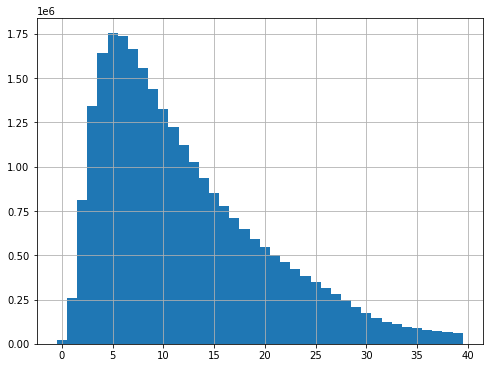

In [64]:
th2.duration_minutes.hist(bins = (np.arange(41)-0.5))

In [65]:
# Do we want to remove very short rides?

# Repeated checkouts overstate demand (quick returns for replacement bikes)

# How can we tell?
# Let's look at the fraction of rides with start_loc==end_loc, as a function of duration (0 to 59)
tic=time.time()
th2['no_travel'] = th2.start_station_number==th2.end_station_number
print(sum(th2.no_travel)/len(th2))

df_vc_minutes= pd.concat([vc_minutes,th2.groupby('duration_minutes')['no_travel'].sum().astype(int)],axis=1)
df_vc_minutes['frac_stationary'] = df_vc_minutes.no_travel / df_vc_minutes.vc_minutes
print(time.time()-tic) # 10s

0.04190964839246037
5.415058612823486


In [66]:
df_vc_minutes_reduced = df_vc_minutes[df_vc_minutes.vc_minutes>=10000]

In [67]:
df_vc_minutes_reduced.iloc[[0,1,2,3,4,5,20,40,60,80,100]]

vc_minutes  no_travel  frac_stationary
0         24059      18509         0.769317
1        256090      61321         0.239451
2        812080      28922         0.035615
3       1342296      20591         0.015340
4       1644346      18752         0.011404
5       1753866      18133         0.010339
20       547592      16434         0.030011
40        59750       7500         0.125523
60        27859       6420         0.230446
80        17047       4960         0.290960
100       10599       3392         0.320030

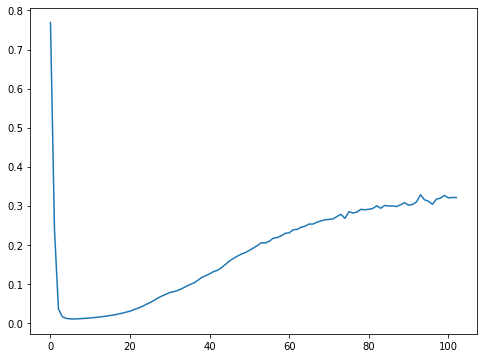

In [68]:
df_vc_minutes_reduced.frac_stationary.plot()

# For EDA, repeat this plot and distinguish member vs casual too

In [69]:
df_vc_minutes_reduced.iloc[:15]

vc_minutes  no_travel  frac_stationary
0        24059      18509         0.769317
1       256090      61321         0.239451
2       812080      28922         0.035615
3      1342296      20591         0.015340
4      1644346      18752         0.011404
5      1753866      18133         0.010339
6      1738393      17432         0.010028
7      1664973      17582         0.010560
8      1558726      17396         0.011160
9      1439336      17094         0.011876
10     1328229      17055         0.012840
11     1222056      16602         0.013585
12     1120399      16500         0.014727
13     1023981      16394         0.016010
14      935348      16209         0.017329

In [70]:
# Fascinating. There are 6k rides with (start!=end) but duration less than 1 minute???
tic=time.time()
teleporters = th2[(~th2.no_travel)&(th2.duration_minutes==0)]
print(time.time()-tic)

0.1060171127319336


In [71]:
len(teleporters)

5550

In [72]:
teleporters.head(20)
# No teleporters before April 2020 (previously those rides were discarded from the dataset before publication)

start_dt              end_dt         start_dt_str  \
26598434 2020-04-02 12:32:06 2020-04-02 12:33:00  2020-04-02 12:32:06   
26599758 2020-04-02 19:20:26 2020-04-02 19:21:16  2020-04-02 19:20:26   
26600408 2020-04-03 11:11:12 2020-04-03 11:11:12  2020-04-03 11:11:12   
26607196 2020-04-05 13:52:58 2020-04-05 13:52:58  2020-04-05 13:52:58   
26610892 2020-04-06 13:42:02 2020-04-06 13:43:01  2020-04-06 13:42:02   
26615754 2020-04-08 14:00:40 2020-04-08 14:01:02  2020-04-08 14:00:40   
26615761 2020-04-08 14:02:30 2020-04-08 14:02:55  2020-04-08 14:02:30   
26619296 2020-04-09 16:58:38 2020-04-09 16:59:32  2020-04-09 16:58:38   
26636507 2020-04-16 18:13:37 2020-04-16 18:14:27  2020-04-16 18:13:37   
26636608 2020-04-16 18:34:45 2020-04-16 18:35:37  2020-04-16 18:34:45   
26636681 2020-04-16 18:50:36 2020-04-16 18:50:36  2020-04-16 18:50:36   
26636690 2020-04-16 18:53:04 2020-04-16 18:53:59  2020-04-16 18:53:04   
26637301 2020-04-17 09:26:21 2020-04-17 09:27:15  2020-04-17 09:26:21   
26637926 2020-04-17 14:53:59 2020-04-17 14:54:56  2020-04-17 14:53:59   
26638490 2020-04-17 17:38:41 2020-04-17 17:39:38  2020-04-17 17:38:41   
26639315 2020-04-18 07:58:57 2020-04-18 07:59:56  2020-04-18 07:58:57   
26641800 2020-04-18 21:12:15 2020-04-18 21:12:39  2020-04-18 21:12:15   
26644649 2020-04-19 15:33:28 2020-04-19 15:33:54  2020-04-19 15:33:28   
26646534 2020-04-19 22:58:14 2020-04-19 22:59:11  2020-04-19 22:58:14   
26650759 2020-04-21 22:21:49 2020-04-21 22:22:43  2020-04-21 22:21:49   

         start_station_number                            start_station_name  \
26598434                31600                                 5th & K St NW   
26599758                31278                                18th & R St NW   
26600408                31642                              4th St & K St NW   
26607196                31651                             11th & Park Rd NW   
26610892                31111                                10th & U St NW   
26615754                31024  Virginia Square Metro / Monroe St & 9th St N   
26615761                31298                                15th & M St NW   
26619296                31607                                13th & E St SE   
26636507                31607                                13th & E St SE   
26636608                31644                 12th St & Pennsylvania Ave SE   
26636681                31322                   48th Pl & MacArthur Blvd NW   
26636690                31607                                13th & E St SE   
26637301                31600                                 5th & K St NW   
26637926                31282                                16th & R St NW   
26638490                31647                 7th St & Massachusetts Ave NE   
26639315                31245                  7th & R St NW / Shaw Library   
26641800                32036                     Fenton St & Ellsworth Dr    
26644649                31611                                13th & H St NE   
26646534                31627                                 3rd & M St NE   
26650759                31127                                22nd & H St NW   

                   end_dt_str end_station_number  \
26598434  2020-04-02 12:33:00              31265   
26599758  2020-04-02 19:21:16              31324   
26600408  2020-04-03 11:11:12              31603   
26607196  2020-04-05 13:52:58              31267   
26610892  2020-04-06 13:43:01              31268   
26615754  2020-04-08 14:01:02              31021   
26615761  2020-04-08 14:02:55              31321   
26619296  2020-04-09 16:59:32              31644   
26636507  2020-04-16 18:14:27              31644   
26636608  2020-04-16 18:35:37              31607   
26636681  2020-04-16 18:50:36              31314   
26636690  2020-04-16 18:53:59              31644   
26637301  2020-04-17 09:27:15              31265   
26637926  2020-04-17 14:54:56              31214   
26638490  2020-04-17 17:39:38              316

In [73]:

# 2b) Duration conclusion
# Conclusion on very short rides:
    # Most are false starts 
        # maybe the person picked a different bike thereafter
    # Of the 6000 (23%) 0-minute rides with StartLoc!=EndLoc:
        # Many are errors. Not physically possible
        # Some are legitimate (ped picks up wheels to go one block b/c why not?)
        
# Solution: we'll throw out all rides with duration less than 1 minute
        # Negative rides are errors anyway (except for a few night rides on Nov 1 2020)
        # Many zero-minute rides are errors too
        # False starts are overstating demand
            # Customer only wanted one bike even if he/she briefly tried others first
        # Even the legitimate short transportation rides may be overstating true system demand
            # Crime of opportunity rather than intent. Customer doesn't really care (3 minute walk)
            # or they are bike upgrades
                # would be a slight geo redistribution that should averaging out to zero anyway

#### Missing Location

In [74]:
# Many rides are missing start location (station_id,station_name) and/or end location
    # Why?

In [75]:
tic=time.time()
is_missing_orig_or_dest = (th2.start_station_number.isnull() | th2.end_station_number.isnull()).rename('missing_O_or_D')
th_missing_location = th2[is_missing_orig_or_dest]
print(th_missing_location.start_dt_str.min())
print(time.time()-tic)
pd.concat([th_missing_location.head(5),th_missing_location.tail(6)],axis=0)

2020-04-01 07:41:49
1.8879995346069336


start_dt              end_dt         start_dt_str  \
26596257 2020-04-01 07:41:49 2020-04-01 08:04:57  2020-04-01 07:41:49   
26596305 2020-04-01 08:16:31 2020-04-01 14:30:21  2020-04-01 08:16:31   
26596352 2020-04-01 08:45:54 2020-04-01 08:53:52  2020-04-01 08:45:54   
26596355 2020-04-01 08:47:23 2020-04-01 09:12:04  2020-04-01 08:47:23   
26596427 2020-04-01 09:47:24 2020-04-01 10:04:04  2020-04-01 09:47:24   
28275413 2020-12-31 23:19:41 2020-12-31 23:21:54  2020-12-31 23:19:41   
28275414 2020-12-31 23:20:22 2021-01-01 00:10:24  2020-12-31 23:20:22   
28275416 2020-12-31 23:22:34 2020-12-31 23:30:40  2020-12-31 23:22:34   
28275434 2020-12-31 23:45:25 2020-12-31 23:59:46  2020-12-31 23:45:25   
28275437 2020-12-31 23:48:44 2020-12-31 23:57:43  2020-12-31 23:48:44   
28275441 2020-12-31 23:50:27 2021-01-01 00:16:17  2020-12-31 23:50:27   

         start_station_number       start_station_name           end_dt_str  \
26596257                31064           Gravelly Point  2020-04-01 08:04:57   
26596305                31283           14th & L St NW  2020-04-01 14:30:21   
26596352                31525      Trinidad Rec Center  2020-04-01 08:53:52   
26596355                31288   4th St & Madison Dr NW  2020-04-01 09:12:04   
26596427                31600            5th & K St NW  2020-04-01 10:04:04   
28275413                31107  Lamont & Mt Pleasant NW  2020-12-31 23:21:54   
28275414                  NaN                      NaN  2021-01-01 00:10:24   
28275416                  NaN                      NaN  2020-12-31 23:30:40   
28275434                  NaN                      NaN  2020-12-31 23:59:46   
28275437                  NaN                      NaN  2020-12-31 23:57:43   
28275441                  NaN                      NaN  2021-01-01 00:16:17   

         end_station_number     end_station_name  duration  member  \
26596257                NaN                  NaN    1388.0  member   
26596305                NaN                  NaN   22430.0  casual   
26596352                NaN                  NaN     478.0  member   
26596355                NaN                  NaN    1481.0  member   
26596427                NaN                  NaN    1000.0  member   
28275413                NaN                  NaN     133.0  member   
28275414                NaN                  NaN    3002.0  casual   
28275416              31123  14th & Girard St NW     486.0  member   
28275434                NaN                  NaN     861.0  casual   
28275437                NaN                  NaN     539.0  member   
28275441                NaN                  NaN    1550.0  member   

          calc_duration  duration_minutes  no_travel  
26596257           1388                23      False  
26596305          22430               373      False  
26596352            478                 7      False  
26596355           1481                24      False  
26596427           1000                16      False  
28275413            133                 2      False  
28275414           3002                50      False  
28275416            486                 8      False  
28275434            861                14      False  
28275437            539                 8      False  
28275441           1550                25      False

In [76]:
# All rows with missing location info (origin and/or destination) came from files in newest format.

In [77]:
is_format1 = pd.Series([False]*idx_split+[True]*(len(th2)-idx_split))

In [78]:
pd.crosstab(is_missing_orig_or_dest[is_format1],df_th.rideable_type[is_format1])

rideable_type   classic_bike  docked_bike  electric_bike
missing_O_or_D                                          
False                  48285      1385415         117423
True                     371         6155         121653

In [79]:
# Electric bike rides are missing O and/or D about half the time
# Classic/docked rides almost always include that info
    # about 0.5% of C/D rides missing O and/or D

# Reason: eBikes don't require docking at a station.
# Can be locked to any public rack and then unlocked electronically by the next customer
    # So these are not errors but real data

# the C/D entries here are probably errors/missing data
    # e.g. occasionally a kiosk will go offline even while remaining operational
        # my example WR&4MR to CC 

# Options
    # A) Discard rows missing O or D
        # Easy
        # Sampling Bias?
    # B) Assign E-Bike rides to nearest dock
        # Pro: Price-Inelastic Consumers may sub e-bike rides for classic rides when given the opportunity
            # Some portion of the real demand for docked bikeshare is being served by this option
        # Con: Many E-bike rides are locked far from any docks
            # Are these substituting for docked bikeshare + long walk? Or Subbing for alt transportation?
            
# My Solution: 
    # Easy way out: We'll Discard all rows missing an O or D

In [80]:
# Next Analysis: let's look at scatter plot of distance traveled vs ride duration

In [81]:
pd.concat([th2.head(2),th2.iloc[(idx_split-2):(idx_split+2)],th2.tail(2)]).iloc[:,:9]

start_dt              end_dt         start_dt_str  \
0        2010-09-20 11:27:04 2010-09-20 11:43:56  2010-09-20 11:27:04   
1        2010-09-20 11:41:22 2010-09-20 11:42:23  2010-09-20 11:41:22   
26596142 2020-03-31 23:41:17 2020-03-31 23:50:43  2020-03-31 23:41:17   
26596143 2020-03-31 23:45:05 2020-04-01 00:02:40  2020-03-31 23:45:05   
26596144 2020-04-01 00:25:48 2020-04-01 00:27:59  2020-04-01 00:25:48   
26596145 2020-04-01 01:36:09 2020-04-01 01:39:17  2020-04-01 01:36:09   
28275444 2020-12-31 23:55:17 2021-01-01 00:28:37  2020-12-31 23:55:17   
28275445 2020-12-31 23:59:40 2021-01-01 01:17:46  2020-12-31 23:59:40   

         start_station_number          start_station_name  \
0                       31208    M St & New Jersey Ave SE   
1                       31209              1st & N St  SE   
26596142                31603               1st & M St NE   
26596143                31325   Reservoir Rd & 38th St NW   
26596144                31000         Eads St & 15th St S   
26596145                31203  14th & Rhode Island Ave NW   
28275444                32046         River Rd & Landy Ln   
28275445                31288      4th St & Madison Dr NW   

                   end_dt_str end_station_number        end_station_name  \
0         2010-09-20 11:43:56              31108           4th & M St SW   
1         2010-09-20 11:42:23              31209          1st & N St  SE   
26596142  2020-03-31 23:50:43              31256          10th & E St NW   
26596143  2020-04-01 00:02:40              31214   17th & Corcoran St NW   
26596144  2020-04-01 00:27:59              31071     Eads St & 12th St S   
26596145  2020-04-01 01:39:17              31251          12th & L St NW   
28275444  2021-01-01 00:28:37              32053   Medical Center Metro    
28275445  2021-01-01 01:17:46              31288  4th St & Madison Dr NW   

          duration  
0           1012.0  
1             61.0  
26596142     565.0  
26596143    1054.0  
26596144     131.0  
26596145     188.0  
28275444    2000.0  
28275445    4686.0

In [82]:
# First we will need to fix the identification scheme for stations
    # either use terminal numbers or use short ids, but not both
        # update January 2021: fixed at source. All TH files are now based on terminal numbers.
    
    # also there are some further DQ issues to sort out:
    
        # station name changes. Several causes:
            # a) small change in string format but referenced location is identical
            # b) nearby repositioning (station moves ~1 block away, still serves same area)
                # such a move can be permanent or temporary (e.g. construction)
            # c) long-distance relocation (station closes)
                # e.g. Fairlington CC moved to Gravelly Point !!! 
                # same kiosk ?
                # we know that there will exist some LD relocations that aren't even shown in the dataset!!
                    # e.g. 31059: 34th Street Bridge renamed to 4MR and WR retroactively ===> Location errors
                    
        # station number changes:
            # Sometimes a given location changes numbers. How often?
            # Long Bridge Park swapped 31090 for 31071 ? (also 392)
                # Were there two stations there side by side for 4 years (14-18)? I doubt it
                    # perhaps another name error?
                    
            # Dive MSKR (MarketSquareKing&Royal)
                # TH shows MSKR data with numbers 31042 and 238
                    # but 238 DNE at GBFS, which shows MSKR=190
                    # but TH: 190=15th&Mass SE
                    # but GBFS puts that at #154
                    # etc.
        # 32901: Warehouse (Dec 2020)

In [83]:
tic=time.time()
station_nn = pd.concat([th2[['start_station_number','start_station_name']]\
                        .rename(columns={'start_station_number':'number','start_station_name':'name'}),\
                                     th2[['end_station_number','end_station_name']]\
                        .rename(columns={'end_station_number':'number','end_station_name':'name'})],axis=0)\
                    .drop_duplicates()
print(time.time()-tic)

36.00499987602234


In [84]:
print(station_nn.shape)
print(len(station_nn.number.unique()))
print(len(station_nn.name.unique()))

(725, 2)
631
723


In [85]:
station_nn.name.value_counts().head() 
# only two names appear with multiple listings

14th & D St SE                      2
22nd & H St NW                      2
North Capitol St & G Pl NE          1
Wisconsin Ave & Brandywine St NW    1
Prince St & Union St                1
Name: name, dtype: int64

In [86]:
station_nn[station_nn.name.duplicated(keep=False)].sort_values('name')

number            name
729       31607  14th & D St SE
27340887  31663  14th & D St SE
17275677  31127  22nd & H St NW
25897591      0  22nd & H St NW

In [87]:
sum(station_nn.name.duplicated(keep=False))

4

In [88]:
d_number2name = sta_info[['name','short_name']].set_index('short_name')['name'].to_dict()
station_nn['gbfs_name'] = station_nn.number.apply(lambda x: d_number2name.get(x,''))

In [89]:
station_nn[station_nn.number.duplicated(keep=False)].sort_values('number')
# duplicated names at a given number are usually the same location

# some exceptions

number                                               name  \
25897591      0                                     22nd & H St NW   
26063598      0                            22nd & H  NW (disabled)   
22971295  31001                                18th St & S Eads St   
121       31001                                    18th & Eads St.   
21209074  31002                             Crystal Dr & 20th St S   
18        31002                                  20th & Crystal Dr   
51        31003                                  15th & Crystal Dr   
21208170  31003                             Crystal Dr & 15th St S   
208       31004         Aurora Hills Community Ctr/18th & Hayes St   
22969334  31004       Aurora Hills Cmty Ctr / 18th St & S Hayes St   
155       31005            Pentagon City Metro / 12th & S Hayes St   
22970458  31005         Pentagon City Metro / 12th St & S Hayes St   
22971813  31006                          Army Navy Dr & S Joyce St   
196       31006                             S Joyce & Army Navy Dr   
185       31007                Crystal City Metro / 18th & Bell St   
22969502  31007           Crystal City Metro / 18th St & S Bell St   
21210799  31009                             Crystal Dr & 27th St S   
22        31009                                  27th & Crystal Dr   
182       31010                              S Glebe & Potomac Ave   
22970654  31010                           S Glebe Rd & Potomac Ave   
29        31011                                  23rd & Crystal Dr   
21208258  31011                             Crystal Dr & 23rd St S   
22970769  31012                               Clark St & 26th St S   
186       31012                                  26th & S Clark St   
22970533  31013                                Eads St & 22nd St S   
914       31013                                   Eads & 22nd St S   
22969312  31014                            Lynn St & 19th St North   
303187    31014                               Lynn & 19th St North   
303542    31018                               N Rhodes & 16th St N   
22969704  31018                              Rhodes St & 16th St N   
1257055   31020                          Wilson Blvd & Franklin Rd   
22969242  31020                        Wilson Blvd & N Franklin Rd   
22969567  31024       Virginia Square Metro / Monroe St & 9th St N   
1494326   31024     Virginia Square Metro / N Monroe St & 9th St N   
1494574   31025          Central Library / N Quincy St & 10th St N   
22971782  31025            Central Library / Quincy St & 10th St N   
1839165   31028                                N Veitch & Key Blvd   
22971302  31028                             N Veitch St & Key Blvd   
22970080  31029                            N Veitch St & 20th St N   
1837459   31029                              N Veitch  & 20th St N   
22970055  31031                               15th St & N Scott St   
1848088   31031                                  15th & N Scott St   
1857950   31034                         N Randolph St & Fairfax Dr   
22969470  31034                         Fairfax Dr & N Randolph St   
1873840   31037               Ballston Metro / N Stuart & 9th St N   
22969795  31037              Ballston Metro / Stuart St & 9th St N   
22488849  31040                      GMU / Fairfax Dr & Kenmore St   
2101708   31040                            Fairfax Dr & Kenmore St   
27724350  31043                            St Asaph & Pendleton St   
2682091   31043                     Saint Asaph St & Pendleton  St   
26607078  31043                                  N Pitt & Wythe St   
2382918   31049                               Utah St & 11th St N    
25902946  31049                                Utah St & 11th St N   
3737711   31054  Walter Reed Community Center / Walter Reed Dr ...   
26675971  31054                              Wakefield High School   
22971324  31054                         Walter Reed Dr & 16th St S   
3742556   31055    

In [90]:
# ROW FILTERING for missing data:

# A) member unknown
# B) duration less than 1 minute
# C) start or end station is NaN
# D) start or end station is in {32900,32901, 32902}

# E) also map station number 0 to 31127
    # we won't bother to correct the other numbers that changed

tic=time.time()
mem_unk = (th2.member=='Unknown')
dur_lt1 = (th2.duration<60) # sec
missing_sta = ((th2.start_station_number.isnull()) | (th2.end_station_number.isnull()))
warehouses = set([32900,32901,32902])
has_warehouse = ((th2.start_station_number.isin(warehouses))\
                 | (th2.end_station_number.isin(warehouses)))

keepers = (~(mem_unk | dur_lt1 | missing_sta | has_warehouse))
th3 = th2[keepers].copy()
th3.start_station_number.replace({0:31127},inplace=True)
th3.end_station_number.replace({0:31127},inplace=True)
print(time.time()-tic)
# throwing out 156K rides, out of 27M (less than one percent)

35.985018253326416


In [91]:
tic=time.time()
nnnnn = th3.isnull().sum()
print(time.time()-tic) # 15s
print(nnnnn)
# excellent: no more nulls

10.993001461029053
start_dt                0
end_dt                  0
start_dt_str            0
start_station_number    0
start_station_name      0
end_dt_str              0
end_station_number      0
end_station_name        0
duration                0
member                  0
calc_duration           0
duration_minutes        0
no_travel               0
dtype: int64


### Geospatial EDA

In [92]:
print(len(th3.start_station_number.unique()))
print(len(th3.end_station_number.unique()))
print(set(th3.start_station_number.unique())==set(th3.end_station_number.unique()))

626
626
True


In [93]:
# Popular Stations:

In [94]:
th3.groupby(['start_station_number','start_station_name']).start_station_number.count().sort_values(ascending=False).head(10)

start_station_number  start_station_name                                 
31623                 Columbus Circle / Union Station                        552281
31200                 Massachusetts Ave & Dupont Circle NW                   474464
31258                 Lincoln Memorial                                       414853
31201                 15th & P St NW                                         387227
31247                 Jefferson Dr & 14th St SW                              377182
31229                 New Hampshire Ave & T St NW                            320093
31241                 Thomas Circle                                          302366
31101                 14th & V St NW                                         301801
31613                 Eastern Market Metro / Pennsylvania Ave & 7th St SE    296200
31214                 17th & Corcoran St NW                                  281081
Name: start_station_number, dtype: int64

In [95]:
th3.start_station_number.value_counts().head(10)

31623    552281
31200    474464
31258    414853
31201    387227
31247    377182
31229    320093
31101    303774
31241    302366
31613    297828
31214    281081
Name: start_station_number, dtype: int64

#### Ride Distances 

In [96]:
lats = sta_info[['short_name','lat']].set_index('short_name')['lat'].to_dict()
lons = sta_info[['short_name','lon']].set_index('short_name')['lon'].to_dict()

In [97]:
# compute distances
d_distances = {}
earth_radius = 3960 # miles
deglat_2_miles = 2*np.pi*earth_radius/360.0  # 69.1 miles per deg lat
earth_latitude_washdc = 38.9101 # deg
longitude_multiplier = np.cos(np.pi*earth_latitude_washdc/180.0)

tic=time.time()
for k1 in sta_info.short_name:
    for k2 in sta_info.short_name:
        dlat = lats[k2]-lats[k1]
        dlon = (lons[k2]-lons[k1])*longitude_multiplier
        dist = np.sqrt(dlat*dlat+dlon*dlon) * deglat_2_miles
        d_distances[(k1,k2)] = dist
print(time.time()-tic)    

1.2240049839019775


In [98]:
tic=time.time()
all_lat = th3.iloc[:3000000].start_station_number.map(lats)
print(time.time()-tic)

0.046999216079711914


In [99]:
# th3.iloc[:30000].apply(lambda x: (x.start_station_number,x.end_station_number),axis=1)
        # is very SLOW !!!
    
tic=time.time()
th3['tup_stations'] = list(zip(th3.start_station_number.iloc[:], th3.end_station_number.iloc[:]))
print(time.time()-tic) # MUCH FASTER: 20s

24.440309286117554


In [100]:
th3.head()

start_dt              end_dt         start_dt_str  \
0 2010-09-20 11:27:04 2010-09-20 11:43:56  2010-09-20 11:27:04   
1 2010-09-20 11:41:22 2010-09-20 11:42:23  2010-09-20 11:41:22   
2 2010-09-20 12:05:37 2010-09-20 12:50:27  2010-09-20 12:05:37   
3 2010-09-20 12:06:05 2010-09-20 12:29:32  2010-09-20 12:06:05   
4 2010-09-20 12:10:43 2010-09-20 12:34:17  2010-09-20 12:10:43   

   start_station_number             start_station_name           end_dt_str  \
0                 31208       M St & New Jersey Ave SE  2010-09-20 11:43:56   
1                 31209                 1st & N St  SE  2010-09-20 11:42:23   
2                 31600                  5th & K St NW  2010-09-20 12:50:27   
3                 31600                  5th & K St NW  2010-09-20 12:29:32   
4                 31100  19th St & Pennsylvania Ave NW  2010-09-20 12:34:17   

   end_station_number               end_station_name  duration  member  \
0               31108                  4th & M St SW    1012.0  Member   
1               31209                 1st & N St  SE      61.0  Member   
2               31100  19th St & Pennsylvania Ave NW    2690.0  Member   
3               31602        Park Rd & Holmead Pl NW    1406.0  Member   
4               31201                 15th & P St NW    1413.0  Member   

   calc_duration  duration_minutes  no_travel    tup_stations  
0           1012                16      False  (31208, 31108)  
1             61                 1       True  (31209, 31209)  
2           2690                44      False  (31600, 31100)  
3           1407                23      False  (31600, 31602)  
4           1414                23      False  (31100, 31201)

In [101]:
print(len(th3.start_station_number.unique()))
print(len(th3.end_station_number.unique()))

626
626


In [102]:
len(th3)

28119479

In [103]:
tic=time.time()
th3['distance']=th3.tup_stations.iloc[:].map(d_distances) 
print(time.time()-tic) # 50 s

# why is this very slow for small N (several seconds even for N=100)

55.02222514152527


In [104]:
len(th2)-len(th3)

155967

In [105]:
tic=time.time()
print(th3.member.str.lower().unique())
print(time.time()-tic)

['member' 'casual']
20.052496194839478


In [106]:
tic=time.time()
th3['is_member'] = th3.member.str.lower()=='member'
print(time.time()-tic)

8.211018323898315


In [107]:
th3.member.value_counts()

Member    21191414
Casual     5404672
member      817830
casual      705563
Name: member, dtype: int64

In [108]:
th3.is_member.value_counts()

True     22009244
False     6110235
Name: is_member, dtype: int64

In [109]:
th3.tail(10)

start_dt              end_dt         start_dt_str  \
28275433 2020-12-31 23:39:25 2020-12-31 23:54:03  2020-12-31 23:39:25   
28275435 2020-12-31 23:48:19 2021-01-01 00:03:21  2020-12-31 23:48:19   
28275436 2020-12-31 23:48:41 2021-01-01 01:00:58  2020-12-31 23:48:41   
28275438 2020-12-31 23:48:58 2021-01-01 01:00:54  2020-12-31 23:48:58   
28275439 2020-12-31 23:50:24 2021-01-01 00:04:00  2020-12-31 23:50:24   
28275440 2020-12-31 23:50:26 2021-01-01 00:04:22  2020-12-31 23:50:26   
28275442 2020-12-31 23:52:40 2021-01-01 00:05:03  2020-12-31 23:52:40   
28275443 2020-12-31 23:54:21 2021-01-01 01:17:55  2020-12-31 23:54:21   
28275444 2020-12-31 23:55:17 2021-01-01 00:28:37  2020-12-31 23:55:17   
28275445 2020-12-31 23:59:40 2021-01-01 01:17:46  2020-12-31 23:59:40   

          start_station_number                           start_station_name  \
28275433                 31636           New Jersey Ave & N St NW/Dunbar HS   
28275435                 31239            Rhode Island & Connecticut Ave NW   
28275436                 31247                    Jefferson Dr & 14th St SW   
28275438                 31247                    Jefferson Dr & 14th St SW   
28275439                 31660                                8th & K St NE   
28275440                 31660                                8th & K St NE   
28275442                 31289  Henry Bacon Dr & Lincoln Memorial Circle NW   
28275443                 31288                       4th St & Madison Dr NW   
28275444                 32046                          River Rd & Landy Ln   
28275445                 31288                       4th St & Madison Dr NW   

                   end_dt_str  end_station_number  \
28275433  2020-12-31 23:54:03               31113   
28275435  2021-01-01 00:03:21               31627   
28275436  2021-01-01 01:00:58               31258   
28275438  2021-01-01 01:00:54               31258   
28275439  2021-01-01 00:04:00               31618   
28275440  2021-01-01 00:04:22               31618   
28275442  2021-01-01 00:05:03               31248   
28275443  2021-01-01 01:17:55               31288   
28275444  2021-01-01 00:28:37               32053   
28275445  2021-01-01 01:17:46               31288   

                                           end_station_name  duration  member  \
28275433                        Columbia Rd & Belmont St NW     878.0  casual   
28275435                                      3rd & M St NE     902.0  casual   
28275436                                   Lincoln Memorial    4337.0  casual   
28275438                                   Lincoln Memorial    4316.0  casual   
28275439                           4th & East Capitol St NE     816.0  member   
28275440                           4th & East Capitol St NE     836.0  member   
28275442  Smithsonian-National Mall / Jefferson Dr & 12t...     743.0  casual   
28275443                             4th St & Madison Dr NW    5014.0  casual   
28275444                              Medical Center Metro     2000.0  casual   
28275445                             4th St & Madison Dr NW    4686.0  casual   

          calc_duration  duration_minutes  no_travel    tup_stations  \
28275433            878                14      False  (31636, 31113)   
28275435            902                15      False  (31239, 31627)   
28275436           4337                72      False  (31247, 31258)   
28275438           4316                71      False  (31247, 31258)   
28275439            816                13      False  (31660, 31618)   
28275440            836                13      False  (31660, 31618)   
28275442            743                12      False  (31289, 31248)   
28275443           5014                83       True  (31288, 31288)   
28275444           2000                33      False  (32046, 32053)   
28275445           4686                78       True  (31288, 31288)   

          distance  is_member  
28275433  1.780248      False  
28275435  2.0

In [110]:
# For plotting, choose a random sample

In [111]:
# pandas sample is slow. numpy random is much faster
tic=time.time()
np.random.seed(0)
my_sample_iloc = (np.random.choice(len(th3),5000,replace=False))
print(time.time()-tic)

1.7109992504119873


In [112]:
tic=time.time()
my_sample = th3.iloc[my_sample_iloc]
print(time.time()-tic)

18.21515703201294


In [113]:
my_sample

start_dt              end_dt         start_dt_str  \
13005439 2016-05-17 15:09:38 2016-05-17 15:16:53  2016-05-17 15:09:38   
23880096 2019-05-29 16:38:27 2019-05-29 17:06:01  2019-05-29 16:38:27   
20561559 2018-06-12 18:20:35 2018-06-12 18:33:49  2018-06-12 18:20:35   
14868538 2016-10-26 06:37:55 2016-10-26 07:29:01  2016-10-26 06:37:55   
19444818 2018-02-26 14:58:10 2018-02-26 15:12:04  2018-02-26 14:58:10   
...                      ...                 ...                  ...   
790253   2011-08-05 09:49:02 2011-08-05 09:57:47  2011-08-05 09:49:02   
6406091  2014-04-09 22:50:18 2014-04-10 00:04:25  2014-04-09 22:50:18   
11670084 2015-11-06 22:38:09 2015-11-06 22:42:23  2015-11-06 22:38:09   
8809996  2014-12-23 10:20:03 2014-12-23 10:26:41  2014-12-23 10:20:03   
10246914 2015-06-29 17:40:24 2015-06-29 17:52:07  2015-06-29 17:40:24   

          start_station_number  \
13005439                 31110   
23880096                 31080   
20561559                 31089   
14868538                 31041   
19444818                 31924   
...                        ...   
790253                   31215   
6406091                  31208   
11670084                 31613   
8809996                  31039   
10246914                 31279   

                                         start_station_name  \
13005439                           20th St & Florida Ave NW   
23880096                               Lee Hwy & N Scott St   
20561559              Court House Metro / 15th & N Uhle St    
14868538                               Prince St & Union St   
19444818                            Wilson Blvd & N Troy St   
...                                                     ...   
790253                       Georgetown Harbor / 30th St NW   
6406091                            M St & New Jersey Ave SE   
11670084  Eastern Market Metro / Pennsylvania Ave & 7th ...   
8809996                           Wilson Blvd & N Quincy St   
10246914                                     19th & G St NW   

                   end_dt_str  end_station_number  \
13005439  2016-05-17 15:16:53               31267   
23880096  2019-05-29 17:06:01               31037   
20561559  2018-06-12 18:33:49               31034   
14868538  2016-10-26 07:29:01               31279   
19444818  2018-02-26 15:12:04               31017   
...                       ...                 ...   
790253    2011-08-05 09:57:47               31224   
6406091   2014-04-10 00:04:25               31613   
11670084  2015-11-06 22:42:23               31269   
8809996   2014-12-23 10:26:41               31078   
10246914  2015-06-29 17:52:07               31247   

                                           end_station_name  duration  member  \
13005439                     17th St & Massachusetts Ave NW     434.0  Member   
23880096              Ballston Metro / Stuart St & 9th St N    1654.0  Member   
20561559                         N Randolph St & Fairfax Dr     793.0  Casual   
14868538                                     19th & G St NW    3065.0  Member   
19444818                            Wilson Blvd & N Uhle St     834.0  Member   
...                                                     ...       ...     ...   
790253                                       19th & L St NW     524.0  Member   
6406091   Eastern Market Metro / Pennsylvania Ave & 7th ...    4447.0  Casual   
11670084                       3rd St & Pennsylvania Ave SE     254.0  Member   
8809996            Arlington Blvd & S George Mason Dr/NFATC     398.0  Member   
10246914                          Jefferson Dr & 14th St SW     703.0  Member   

          calc_duration  duration_minutes  no_travel    tup_stations  \
13005439            435                 7      False  (31110, 31267)   
23880096           1654                27      False  (31080, 31037)   
20561559            794                13      False  (31089, 31034)   
14868538           3066                51      False  (31041, 31279)   
1944481

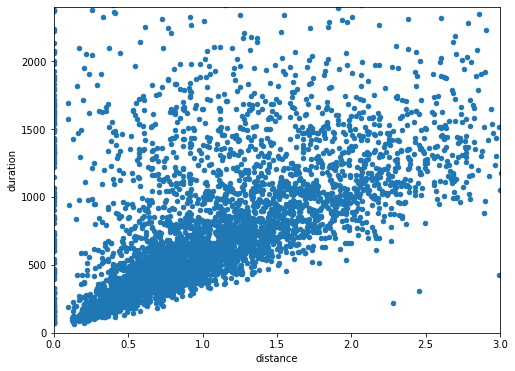

In [114]:
my_sample.plot.scatter('distance','duration',xlim=(0,3),ylim=(0,2400))

In [115]:
sum(th3.distance.isnull())
# 72K distance computations failed. These are station numbers that don't exist in current station_information.json
# Past locations that have been removed
# For th4, we'll throw those out, since we're not going to be predicting on those locs anyway
# Then all stations should have matches

72295

In [116]:
u_sta = th3.start_station_number.unique()
extinct_station_numbers = set([ss for ss in u_sta if ss not in sta_info.short_name.values])
print(extinct_station_numbers)
print(th3[th3.start_station_number.isin(extinct_station_numbers)]\
      [['start_station_number','start_station_name']].drop_duplicates())
# These 8 stations no longer exist.

{31008, 32068, 32202, 32015, 32020, 31709, 32030, 32031}
          start_station_number              start_station_name
262                      31008             12th & Army Navy Dr
4277960                  31709      34th St & Minnesota Ave SE
5490998                  32020  Crabbs Branch Way & Calhoun Pl
5491180                  32015  Crabbs Branch Way & Redland Rd
5558609                  32031             Taft St & E Gude Dr
5576678                  32030        Broschart & Blackwell Rd
14823554                 32202       Solutions & Greensboro Dr
16496229                 32068       Columbus Ave & Tribeca St


In [117]:
# We'll discard these 72K rides for simplicity
    # Selection Bias
tic=time.time()
keepcols = ['start_dt','start_station_number','end_dt','end_station_number']  # discarding is_member also
th4 = th3.iloc[:].loc[~th3.iloc[:].distance.isnull(),keepcols]
print(time.time()-tic)

8.624001026153564


### Binning by timestamp and location

In [118]:
row_limit = len(th4)
tic=time.time()
start_bins = th4.iloc[:row_limit].groupby([\
                              th4.start_dt.iloc[:row_limit].dt.year,\
                              th4.start_dt.iloc[:row_limit].dt.dayofyear,\
                              th4.start_dt.iloc[:row_limit].dt.hour,\
                                   th4.start_station_number.iloc[:row_limit],
                             ])['start_dt'].count().rename('bikes')
end_bins = th4.iloc[:row_limit].groupby([\
                              th4.end_dt.iloc[:row_limit].dt.year,\
                              th4.end_dt.iloc[:row_limit].dt.dayofyear,\
                              th4.end_dt.iloc[:row_limit].dt.hour,\
                                   th4.end_station_number.iloc[:row_limit],
                             ])['end_dt'].count().rename('docks')
print(time.time()-tic)

25.303999423980713


In [119]:
usta4_s = th4.start_station_number.unique()
usta4_e = th4.end_station_number.unique()
assert (set(usta4_s)==set(usta4_e))
usta4 = sorted(usta4_s)
print(usta4)

[31000, 31001, 31002, 31003, 31004, 31005, 31006, 31007, 31009, 31010, 31011, 31012, 31013, 31014, 31015, 31016, 31017, 31018, 31019, 31020, 31021, 31022, 31023, 31024, 31025, 31026, 31027, 31028, 31029, 31030, 31031, 31032, 31033, 31034, 31035, 31036, 31037, 31038, 31039, 31040, 31041, 31042, 31043, 31044, 31045, 31046, 31047, 31048, 31049, 31050, 31051, 31052, 31053, 31054, 31055, 31056, 31057, 31058, 31059, 31060, 31061, 31062, 31063, 31064, 31065, 31066, 31067, 31068, 31069, 31070, 31071, 31072, 31073, 31074, 31075, 31076, 31077, 31078, 31079, 31080, 31081, 31082, 31083, 31084, 31085, 31086, 31087, 31088, 31089, 31090, 31091, 31092, 31093, 31094, 31095, 31096, 31097, 31098, 31099, 31100, 31101, 31102, 31103, 31104, 31105, 31106, 31107, 31108, 31109, 31110, 31111, 31112, 31113, 31114, 31115, 31116, 31117, 31118, 31119, 31120, 31121, 31122, 31123, 31124, 31125, 31126, 31127, 31128, 31129, 31130, 31131, 31132, 31200, 31201, 31202, 31203, 31204, 31205, 31206, 31207, 31208, 31209, 31211

In [120]:
print(start_bins.shape)
print(end_bins.shape)
# for the 90k hours over ten years, there are about 100 stations used per hour, on average

(9587229,)
(9399386,)


### Outlier Bins

In [121]:
# extreme values:
print(start_bins[start_bins==start_bins.max()])  # 2012 NLDS Game 4, Jayson Werth walkoff homer vs STL
print(end_bins[end_bins==end_bins.max()])        # cherry blossoms?

# These extreme values are supported by corrals

start_dt  start_dt  start_dt  start_station_number
2012      285       19        31209                   119
Name: bikes, dtype: int64
end_dt  end_dt  end_dt  end_station_number
2018    90      14      31247                 125
Name: docks, dtype: int64


In [122]:
print(d_number2name[31209])
print(d_number2name[31247])

1st & N St  SE
Jefferson Dr & 14th St SW


In [123]:
print((start_bins[start_bins>80]).sort_values(ascending=False))
# top starts are all Nats playoff games !
# highest non-31209: Lincoln Memorial 2015 July 5

start_dt  start_dt  start_dt  start_station_number
2012      285       19        31209                   119
2014      276       19        31209                   105
2012      284       16        31209                   105
2019      274       23        31209                   101
2016      281       21        31209                   101
          288       0         31209                    93
2019      299       0         31209                    87
          288       23        31209                    86
2017      279       22        31209                    86
2015      184       14        31258                    82
Name: bikes, dtype: int64


In [124]:
print((end_bins[end_bins>80]).sort_values(ascending=False))
# dominated by cherry blossoms
# also:
# Women's March 2017 Jan 21
# arrivals to Nats games
# Independence Day weekend  
# 2019 Nov 02?
    # Washington Nationals Parade plus Second Amendment Rally

end_dt  end_dt  end_dt  end_station_number
2018    90      14      31247                 125
2016    86      16      31247                 113
2017    21      11      31244                 104
2016    86      14      31247                  98
2018    90      13      31247                  96
2016    86      13      31247                  92
                12      31247                  92
                15      31247                  91
        287     19      31209                  88
2019    306     14      31271                  87
2015    184     14      31258                  83
2014    186     15      31258                  83
2018    90      11      31247                  82
2015    102     14      31240                  81
        101     15      31240                  81
2012    284     12      31209                  81
Name: docks, dtype: int64


In [125]:
print(d_number2name[31247])
print(d_number2name[31244])
print(d_number2name[31258])
print(d_number2name[31240])
print(d_number2name[31209])
print(d_number2name[31271])

Jefferson Dr & 14th St SW
4th & E St SW
Lincoln Memorial
Ohio Dr & West Basin Dr SW / MLK & FDR Memorials
1st & N St  SE
Constitution Ave & 2nd St NW/DOL


### Create arrays 'bike' and 'dock'

In [126]:
d_term2staidx = {sta:idx for (idx,sta) in enumerate(usta4)}
bike = np.zeros((num_rows,len(usta4)),dtype=np.uint8)   
dock = np.zeros((num_rows,len(usta4)),dtype=np.uint8)
# uint8 dtype could require upgrade if usage increases. Through 2020, max value has been is 125.

In [127]:
tic=time.time()
dict_startbins = start_bins.iloc[:].to_dict()
dict_endbins = end_bins.iloc[:].to_dict()
print(time.time()-tic)

19.195014476776123


In [128]:
bike = np.zeros((len(ydhw),len(usta4)),dtype=np.uint8)   
dock = np.zeros((len(ydhw),len(usta4)),dtype=np.uint8)

tic=time.time()
for k in start_bins.index.values:
    timeidx = d_ydh2timeidx[tuple(k[:3])]
    staidx = d_term2staidx[k[3]]
    bike[timeidx,staidx] = dict_startbins.get(k)
for k in end_bins.index.values:
    if (k[0]<cut_year): # ignore ending timestamps after cutoff
        timeidx = d_ydh2timeidx[tuple(k[:3])]
        staidx = d_term2staidx[k[3]]
        dock[timeidx,staidx] = dict_endbins.get(k)
print(time.time()-tic)

# 2 minutes to write numpy arrays with bike/dock counts

# Alternative:
            # np.vectorize(dict_startbins.get)(start_bins.iloc[:].index.values)
# doesn't help b/c time is consumed in computation of indices
# masked out bike/dock computations: time drops from 133 to 118 s

122.76659345626831


In [129]:
d_term2staidx

{31000: 0,
 31001: 1,
 31002: 2,
 31003: 3,
 31004: 4,
 31005: 5,
 31006: 6,
 31007: 7,
 31009: 8,
 31010: 9,
 31011: 10,
 31012: 11,
 31013: 12,
 31014: 13,
 31015: 14,
 31016: 15,
 31017: 16,
 31018: 17,
 31019: 18,
 31020: 19,
 31021: 20,
 31022: 21,
 31023: 22,
 31024: 23,
 31025: 24,
 31026: 25,
 31027: 26,
 31028: 27,
 31029: 28,
 31030: 29,
 31031: 30,
 31032: 31,
 31033: 32,
 31034: 33,
 31035: 34,
 31036: 35,
 31037: 36,
 31038: 37,
 31039: 38,
 31040: 39,
 31041: 40,
 31042: 41,
 31043: 42,
 31044: 43,
 31045: 44,
 31046: 45,
 31047: 46,
 31048: 47,
 31049: 48,
 31050: 49,
 31051: 50,
 31052: 51,
 31053: 52,
 31054: 53,
 31055: 54,
 31056: 55,
 31057: 56,
 31058: 57,
 31059: 58,
 31060: 59,
 31061: 60,
 31062: 61,
 31063: 62,
 31064: 63,
 31065: 64,
 31066: 65,
 31067: 66,
 31068: 67,
 31069: 68,
 31070: 69,
 31071: 70,
 31072: 71,
 31073: 72,
 31074: 73,
 31075: 74,
 31076: 75,
 31077: 76,
 31078: 77,
 31079: 78,
 31080: 79,
 31081: 80,
 31082: 81,
 31083: 82,
 31084: 83,
 3

In [130]:
print(np.count_nonzero(bike))
print((len(start_bins)-np.count_nonzero(bike)))
print(np.count_nonzero(dock))
print((len(end_bins)-np.count_nonzero(dock)))
# some rides that ended in 2021 have been discarded from dock array

9587229
0
9399362
24


#### Viz: Rush-hour Asymmetry

In [131]:
# 8am weekdays. Net rides and Volume of Rides
# Net rides heatmap
# Volume = bubble?

In [132]:
# down-select 8am weekdays from numpy matrices:
mask_8am_weekday = ((ydhw[:,2]==8) & (ydhw[:,3]<=4))
total_8amw_bike = bike[mask_8am_weekday].sum(axis=0)
total_8amw_dock = dock[mask_8am_weekday].sum(axis=0)

bd_volume_8amw = total_8amw_bike+total_8amw_dock
inflow_8amw = (total_8amw_dock.astype('int')-total_8amw_bike.astype('int'))/sum(mask_8am_weekday)

In [133]:
# pd.Series(inflow_8amw,index=usta4)

In [134]:
import geopandas as gpd

In [135]:
geostations = gpd.GeoDataFrame(
    sta_info, geometry=gpd.points_from_xy(sta_info.lon, sta_info.lat))
geostations.crs = {'init': 'epsg:4326'}

# View the first five rows of the GeoDataFrame
geostations.head()

C:\Users\rek\Anaconda3\envs\ai\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


capacity  short_name                                          name  \
0        15       31000                           Eads St & 15th St S   
1        11       31001                           18th St & S Eads St   
2        17       31002                        Crystal Dr & 20th St S   
3        16       31003                        Crystal Dr & 15th St S   
4        11       31004  Aurora Hills Cmty Ctr / 18th St & S Hayes St   

   has_kiosk station_type eightd_station_services  \
0       True      classic                      []   
1       True      classic                      []   
2       True      classic                      []   
3       True      classic                      []   
4       True      classic                      []   

                                         rental_uris     rental_methods  \
0  {'ios': 'https://dc.lft.to/lastmile_qr_scan', ...  [KEY, CREDITCARD]   
1  {'ios': 'https://dc.lft.to/lastmile_qr_scan', ...  [KEY, CREDITCARD]   
2  {'ios': 'https://dc.lft.to/lastmile_qr_scan', ...  [KEY, CREDITCARD]   
3  {'ios': 'https://dc.lft.to/lastmile_qr_scan', ...  [KEY, CREDITCARD]   
4  {'ios': 'https://dc.lft.to/lastmile_qr_scan', ...  [KEY, CREDITCARD]   

  legacy_id        lon  eightd_has_key_dispenser  \
0         1 -77.053230                     False   
1         2 -77.053320                     False   
2         3 -77.049232                     False   
3         4 -77.049417                     False   
4         5 -77.059490                     False   

                            external_id  station_id region_id        lat  \
0  082469cc-1f3f-11e7-bf6b-3863bb334450           1        41  38.858971   
1  08246b69-1f3f-11e7-bf6b-3863bb334450           2        41  38.857250   
2  08246c35-1f3f-11e7-bf6b-3863bb334450           3        41  38.856425   
3  08246cd5-1f3f-11e7-bf6b-3863bb334450           4        41  38.861056   
4  08246d68-1f3f-11e7-bf6b-3863bb334450           5        41  38.857866   

   electric_bike_surcharge_waiver                    geometry  
0                           False  POINT (-77.05323 38.85897)  
1                           False  POINT (-77.05332 38.85725)  
2                           False  POINT (-77.04923 38.85643)  
3                           False  POINT (-77.04942 38.86106)  
4                           False  POINT (-77.05949 38.85787)

In [136]:
type(geostations)

geopandas.geodataframe.GeoDataFrame

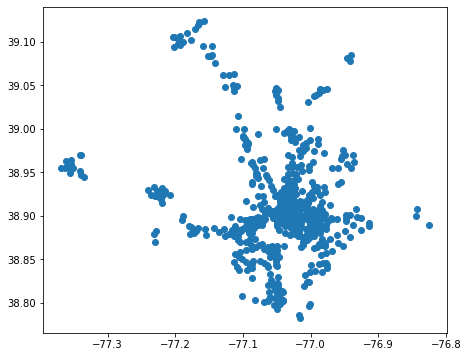

In [137]:
geostations.plot()

In [138]:
print(geostations.crs)

+init=epsg:4326 +type=crs


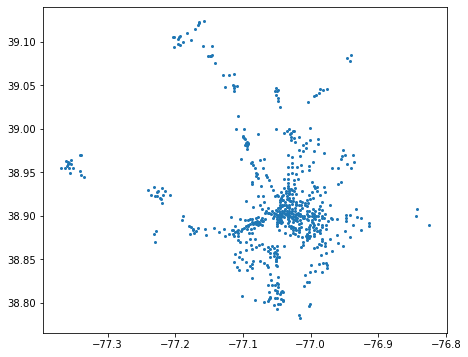

In [139]:
#ax = geostations.plot(figsize=(8,8), color='whitesmoke', linestyle=':', edgecolor='black')
geostations.plot(markersize=4) # ax=ax

In [140]:
geostations['inflow_8amw']=geostations.short_name.map(pd.Series(inflow_8amw,index=usta4))

In [141]:
geostations.head()

capacity  short_name                                          name  \
0        15       31000                           Eads St & 15th St S   
1        11       31001                           18th St & S Eads St   
2        17       31002                        Crystal Dr & 20th St S   
3        16       31003                        Crystal Dr & 15th St S   
4        11       31004  Aurora Hills Cmty Ctr / 18th St & S Hayes St   

   has_kiosk station_type eightd_station_services  \
0       True      classic                      []   
1       True      classic                      []   
2       True      classic                      []   
3       True      classic                      []   
4       True      classic                      []   

                                         rental_uris     rental_methods  \
0  {'ios': 'https://dc.lft.to/lastmile_qr_scan', ...  [KEY, CREDITCARD]   
1  {'ios': 'https://dc.lft.to/lastmile_qr_scan', ...  [KEY, CREDITCARD]   
2  {'ios': 'https://dc.lft.to/lastmile_qr_scan', ...  [KEY, CREDITCARD]   
3  {'ios': 'https://dc.lft.to/lastmile_qr_scan', ...  [KEY, CREDITCARD]   
4  {'ios': 'https://dc.lft.to/lastmile_qr_scan', ...  [KEY, CREDITCARD]   

  legacy_id        lon  eightd_has_key_dispenser  \
0         1 -77.053230                     False   
1         2 -77.053320                     False   
2         3 -77.049232                     False   
3         4 -77.049417                     False   
4         5 -77.059490                     False   

                            external_id  station_id region_id        lat  \
0  082469cc-1f3f-11e7-bf6b-3863bb334450           1        41  38.858971   
1  08246b69-1f3f-11e7-bf6b-3863bb334450           2        41  38.857250   
2  08246c35-1f3f-11e7-bf6b-3863bb334450           3        41  38.856425   
3  08246cd5-1f3f-11e7-bf6b-3863bb334450           4        41  38.861056   
4  08246d68-1f3f-11e7-bf6b-3863bb334450           5        41  38.857866   

   electric_bike_surcharge_waiver                    geometry  inflow_8amw  
0                           False  POINT (-77.05323 38.85897)    -0.392098  
1                           False  POINT (-77.05332 38.85725)    -0.300410  
2                           False  POINT (-77.04923 38.85643)     0.553858  
3                           False  POINT (-77.04942 38.86106)     0.449870  
4                           False  POINT (-77.05949 38.85787)    -1.044726

In [142]:
tic=time.time()
w814 = ((th4.start_dt.dt.dayofweek<=4) & (th4.start_dt.dt.hour==8) & (th4.start_dt.dt.year<=2014))
print(time.time()-tic)

6.41498327255249


In [143]:
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

In [144]:
# Create a map
m_1 = folium.Map(location=[38.90,-77.04], tiles='openstreetmap', zoom_start=14)

def color_producer(val):
    if val > 0:
        return 'forestgreen'
    else:
        return 'darkred'

# Add a bubble map to the base map
for i in range(0,len(geostations)):
    if (not(np.isnan(geostations.iloc[i]['inflow_8amw']))):
        Circle(
            location=[geostations.iloc[i]['lat'],geostations.iloc[i]['lon']],
            radius=100*np.log(1+abs(geostations.inflow_8amw.iloc[i])),
            fill=True,
            fill_color=color_producer(geostations.inflow_8amw.iloc[i]),
            color=color_producer(geostations.inflow_8amw.iloc[i])).add_to(m_1)

# Display the map
m_1

## Weather

In [145]:
table_name='weather'
tic=time.time()
conn = sqlite3.connect('cabi.db')
query = 'select * from '+table_name
w0 = pd.read_sql_query(query,conn)
conn.close()
print(time.time()-tic)
print(w0.shape)
print(w0.columns)

1.600137710571289
(90145, 29)
Index(['address', 'datetime', 'mint', 'maxt', 'temp', 'dew', 'humidity',
       'heatindex', 'wspd', 'wgust', 'wdir', 'windchill', 'precip',
       'precipcover', 'snowdepth', 'visibility', 'cloudcover',
       'sealevelpressure', 'stationinfo', 'weathertype', 'latitude',
       'longitude', 'resolvedAddress', 'name', 'info', 'sunrise', 'sunset',
       'moonphase', 'conditions'],
      dtype='object')


In [146]:
w0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90145 entries, 0 to 90144
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   address           90145 non-null  object 
 1   datetime          90145 non-null  object 
 2   mint              90145 non-null  float64
 3   maxt              90145 non-null  float64
 4   temp              90145 non-null  float64
 5   dew               90144 non-null  float64
 6   humidity          90144 non-null  float64
 7   heatindex         11725 non-null  float64
 8   wspd              90144 non-null  float64
 9   wgust             41099 non-null  float64
 10  wdir              89756 non-null  float64
 11  windchill         25916 non-null  float64
 12  precip            90145 non-null  float64
 13  precipcover       0 non-null      object 
 14  snowdepth         397 non-null    float64
 15  visibility        90142 non-null  float64
 16  cloudcover        90145 non-null  float6

In [147]:
w0.describe()

mint          maxt          temp           dew      humidity  \
count  90145.000000  90145.000000  90145.000000  90144.000000  90144.000000   
mean      59.293419     59.293419     59.293419     45.735093     63.471249   
std       17.658489     17.658489     17.658489     19.052064     18.977735   
min        6.000000      6.000000      6.000000    -14.900000      8.660000   
25%       44.800000     44.800000     44.800000     30.400000     48.320000   
50%       60.100000     60.100000     60.100000     47.900000     63.550000   
75%       74.100000     74.100000     74.100000     62.600000     79.420000   
max      105.300000    105.300000    105.300000     80.300000    100.000000   

          heatindex          wspd         wgust          wdir     windchill  \
count  11725.000000  90144.000000  41099.000000  89756.000000  25916.000000   
mean      88.554891      7.495993     12.717429    189.129763     33.352477   
std        5.888494      4.702135      9.116649    106.564254      9.962976   
min       78.700000      0.000000      0.000000      0.000000    -12.000000   
25%       84.100000      4.400000      5.800000    110.000000     27.900000   
50%       87.300000      6.900000     10.300000    189.000000     34.900000   
75%       92.000000     10.100000     18.300000    296.000000     41.100000   
max      120.800000     41.400000     70.100000    360.000000     49.500000   

             precip   snowdepth    visibility    cloudcover  sealevelpressure  \
count  90145.000000  397.000000  90142.000000  90145.000000      90070.000000   
mean       0.004609   32.414937      9.398064     47.792757       1017.701964   
std        0.033815   63.428585      1.611046     33.869588          7.374722   
min        0.000000    0.000000      0.000000      0.000000        969.500000   
25%        0.000000    1.970000      9.900000     21.000000       1013.000000   
50%        0.000000    3.150000      9.900000     36.500000       1017.500000   
75%        0.000000   11.020000      9.900000     85.300000       1022.300000   
max        2.570000  231.890000      9.900000    100.000000       1045.700000   

         latitude     longitude     moonphase  
count  90145.0000  9.014500e+04  90145.000000  
mean      38.8904 -7.703200e+01      0.501813  
std        0.0000  1.421093e-14      0.307164  
min       38.8904 -7.703200e+01      0.000000  
25%       38.8904 -7.703200e+01      0.250000  
50%       38.8904 -7.703200e+01      0.500000  
75%       38.8904 -7.703200e+01      0.750000  
max       38.8904 -7.703200e+01      1.000000

In [148]:
num_uniqvals_col = pd.Series(w0.columns.map(lambda x: len(w0[x].unique())),index=w0.columns)
constant_columns = list(num_uniqvals_col[num_uniqvals_col==1].index)

In [149]:
w0[constant_columns].head()

address precipcover  latitude  longitude  \
0  Washington,DC        None   38.8904    -77.032   
1  Washington,DC        None   38.8904    -77.032   
2  Washington,DC        None   38.8904    -77.032   
3  Washington,DC        None   38.8904    -77.032   
4  Washington,DC        None   38.8904    -77.032   

                 resolvedAddress                           name  info  
0  Washington, DC, United States  Washington, DC, United States  None  
1  Washington, DC, United States  Washington, DC, United States  None  
2  Washington, DC, United States  Washington, DC, United States  None  
3  Washington, DC, United States  Washington, DC, United States  None  
4  Washington, DC, United States  Washington, DC, United States  None

In [150]:
print(all(w0.mint==w0.temp))
print(all(w0.maxt==w0.temp))
constant_columns.extend(['mint','maxt'])
w1=w0.drop(constant_columns,axis=1)

True
True


In [151]:
w1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90145 entries, 0 to 90144
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   datetime          90145 non-null  object 
 1   temp              90145 non-null  float64
 2   dew               90144 non-null  float64
 3   humidity          90144 non-null  float64
 4   heatindex         11725 non-null  float64
 5   wspd              90144 non-null  float64
 6   wgust             41099 non-null  float64
 7   wdir              89756 non-null  float64
 8   windchill         25916 non-null  float64
 9   precip            90145 non-null  float64
 10  snowdepth         397 non-null    float64
 11  visibility        90142 non-null  float64
 12  cloudcover        90145 non-null  float64
 13  sealevelpressure  90070 non-null  float64
 14  stationinfo       90145 non-null  object 
 15  weathertype       910 non-null    object 
 16  sunrise           90145 non-null  object

In [152]:
w1.stationinfo.str.findall('(?<=Id=)[^,]+').explode().value_counts()
# explode
# Could build boolean feature for inclusion of weather stations
# NO

72405013743    89166
KDCA           81780
99731499999    39031
KCGS           19861
KADW           19513
72224400358     8550
74594013705     7210
72403793728     2882
72033493764      227
72403093738       84
KDAA              63
C8838             38
99999993733       37
KFME               9
99799499999        5
KGAI               2
72406599999        2
Name: stationinfo, dtype: int64

In [153]:
w1.weathertype.unique()
# Lots of categories. Ignoring this

array([None, 'Light Rain', 'Mist, Light Drizzle', 'Mist, Light Rain',
       'Mist', 'Rain, Heavy Rain', 'Light Snow', 'Mist, Light Snow',
       'Mist, Snow', 'Fog, Snow', 'Smoke Or Haze',
       'Mist, Rain, Heavy Rain',
       'Light Snow, Light Rain And Snow, Light Rain',
       'Mist, Light Snow, Light Rain And Snow, Light Rain',
       'Light Drizzle, Fog', 'Ice, Mist, Light Snow', 'Ice',
       'Ice, Light Snow, Light Rain And Snow, Light Rain',
       'Ice, Light Snow',
       'Ice, Mist, Light Snow, Light Rain And Snow, Light Rain',
       'Mist, Rain, Heavy Rain, Light Rain', 'Heavy Rain, Light Rain',
       'Lightning Without Thunder, Light Rain',
       'Light Drizzle, Thunderstorm', 'Fog', 'Thunderstorm, Light Rain',
       'Mist, Rain, Light Rain', 'Lightning Without Thunder',
       'Thunderstorm', 'Rain', 'Squalls, Thunderstorm, Rain, Heavy Rain',
       'Rain, Thunderstorm, Heavy Rain',
       'Mist, Rain, Thunderstorm, Heavy Rain',
       'Mist, Thunderstorm, Light Ra

In [154]:
sunrise_sunset = pd.concat([w1.sunrise,w1.sunset],axis=1)
pd.concat([sunrise_sunset.head(3),sunrise_sunset.tail(3)])
# ignore 

sunrise                     sunset
0      2010-09-20T06:53:53-04:00  2010-09-20T19:08:32-04:00
1      2010-09-20T06:53:53-04:00  2010-09-20T19:08:32-04:00
2      2010-09-20T06:53:53-04:00  2010-09-20T19:08:32-04:00
90142  2020-12-31T07:26:46-05:00  2020-12-31T16:56:16-05:00
90143  2020-12-31T07:26:46-05:00  2020-12-31T16:56:16-05:00
90144  2020-12-31T07:26:46-05:00  2020-12-31T16:56:16-05:00

In [155]:
cols2drop_1 = ['sunrise','sunset','stationinfo','weathertype']
w2=w1.drop(cols2drop_1,axis=1)

In [156]:
w2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90145 entries, 0 to 90144
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   datetime          90145 non-null  object 
 1   temp              90145 non-null  float64
 2   dew               90144 non-null  float64
 3   humidity          90144 non-null  float64
 4   heatindex         11725 non-null  float64
 5   wspd              90144 non-null  float64
 6   wgust             41099 non-null  float64
 7   wdir              89756 non-null  float64
 8   windchill         25916 non-null  float64
 9   precip            90145 non-null  float64
 10  snowdepth         397 non-null    float64
 11  visibility        90142 non-null  float64
 12  cloudcover        90145 non-null  float64
 13  sealevelpressure  90070 non-null  float64
 14  moonphase         90145 non-null  float64
 15  conditions        90145 non-null  object 
dtypes: float64(14), object(2)
memory usage: 

In [157]:
w2.conditions.value_counts()

Partially cloudy          32905
Overcast                  25523
Clear                     25511
Rain, Overcast             3130
Rain, Partially cloudy     2351
Rain                        725
Name: conditions, dtype: int64

In [158]:
w2['rain']=w2.conditions.str.contains('Rain')
w2['overcast']=w2.conditions.str.contains('Overcast')
w2['partially_cloudy']=w2.conditions.str.contains('Partially cloudy')

In [159]:
print(sum(w2.rain))
print(sum(w2.overcast))
print(sum(w2.partially_cloudy))
print(sum(~(w2.rain | w2.overcast | w2.partially_cloudy)))
# Verify correct counts:

6206
28653
35256
25511


In [160]:
w2=w2.drop('conditions',axis=1)

In [161]:
w2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90145 entries, 0 to 90144
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   datetime          90145 non-null  object 
 1   temp              90145 non-null  float64
 2   dew               90144 non-null  float64
 3   humidity          90144 non-null  float64
 4   heatindex         11725 non-null  float64
 5   wspd              90144 non-null  float64
 6   wgust             41099 non-null  float64
 7   wdir              89756 non-null  float64
 8   windchill         25916 non-null  float64
 9   precip            90145 non-null  float64
 10  snowdepth         397 non-null    float64
 11  visibility        90142 non-null  float64
 12  cloudcover        90145 non-null  float64
 13  sealevelpressure  90070 non-null  float64
 14  moonphase         90145 non-null  float64
 15  rain              90145 non-null  bool   
 16  overcast          90145 non-null  bool  

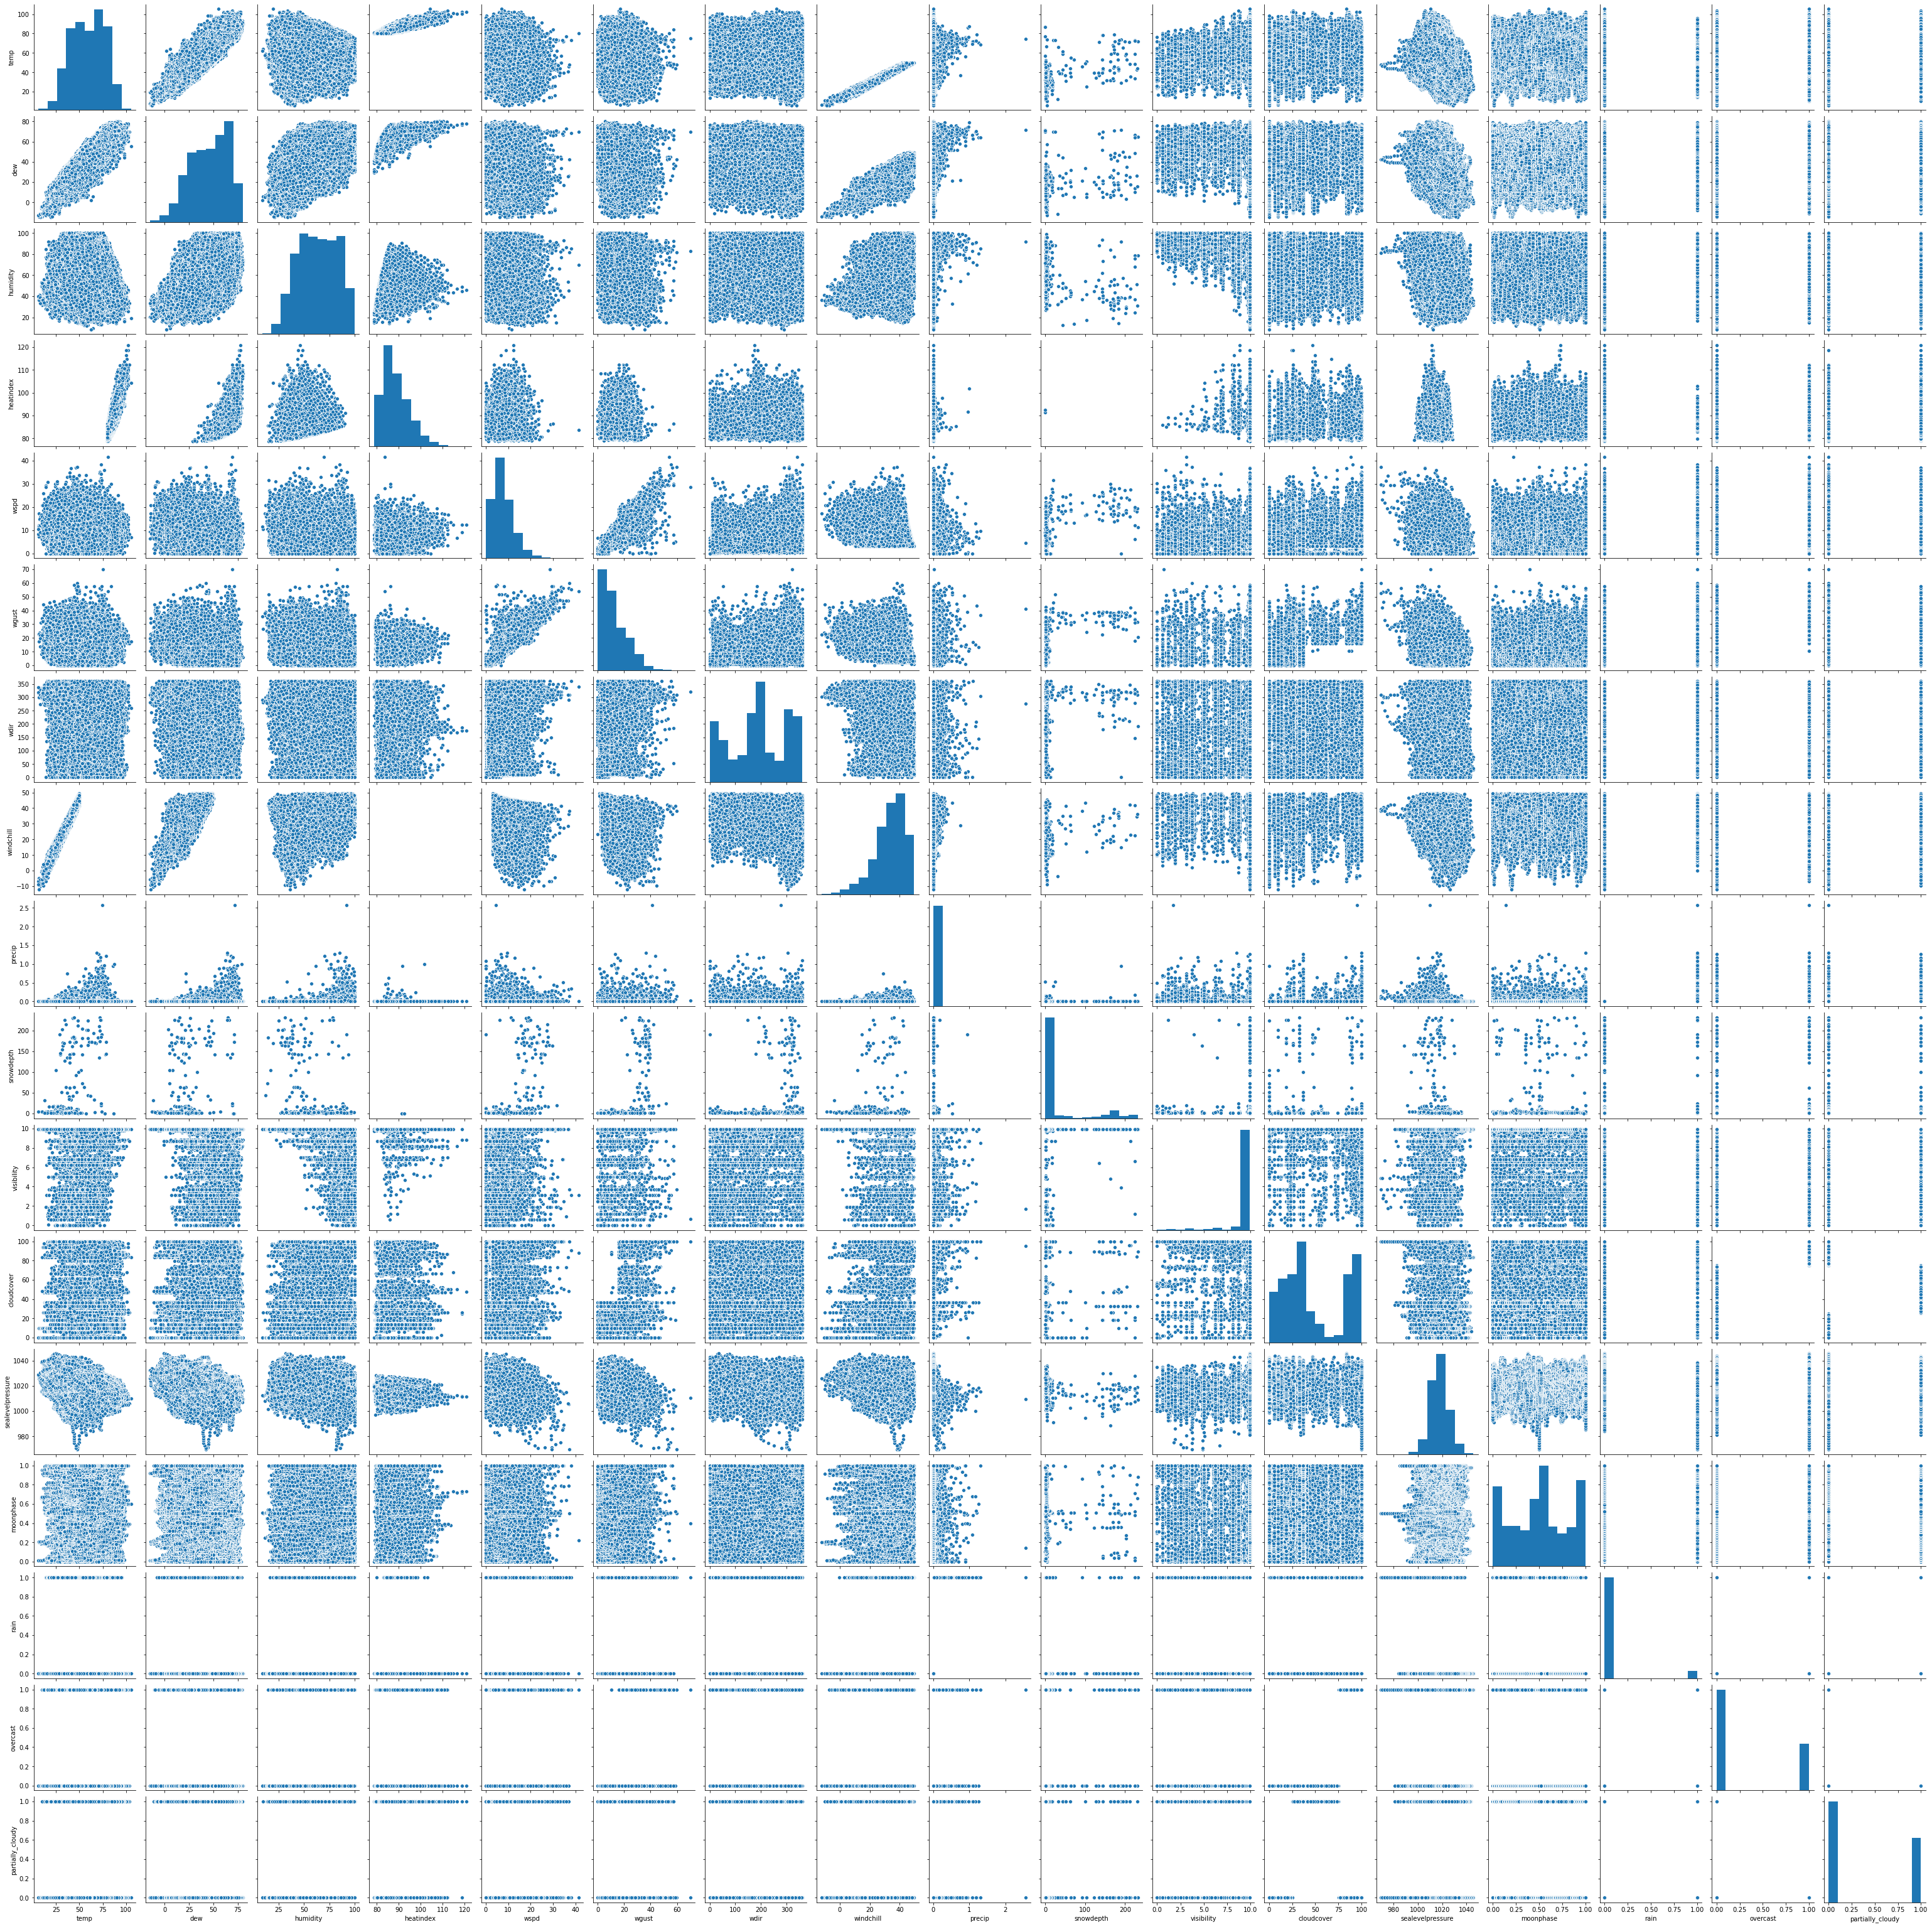

In [162]:
#
sns.pairplot(w2.drop('datetime',axis=1).astype(float))


In [163]:
w2.describe()

temp           dew      humidity     heatindex          wspd  \
count  90145.000000  90144.000000  90144.000000  11725.000000  90144.000000   
mean      59.293419     45.735093     63.471249     88.554891      7.495993   
std       17.658489     19.052064     18.977735      5.888494      4.702135   
min        6.000000    -14.900000      8.660000     78.700000      0.000000   
25%       44.800000     30.400000     48.320000     84.100000      4.400000   
50%       60.100000     47.900000     63.550000     87.300000      6.900000   
75%       74.100000     62.600000     79.420000     92.000000     10.100000   
max      105.300000     80.300000    100.000000    120.800000     41.400000   

              wgust          wdir     windchill        precip   snowdepth  \
count  41099.000000  89756.000000  25916.000000  90145.000000  397.000000   
mean      12.717429    189.129763     33.352477      0.004609   32.414937   
std        9.116649    106.564254      9.962976      0.033815   63.428585   
min        0.000000      0.000000    -12.000000      0.000000    0.000000   
25%        5.800000    110.000000     27.900000      0.000000    1.970000   
50%       10.300000    189.000000     34.900000      0.000000    3.150000   
75%       18.300000    296.000000     41.100000      0.000000   11.020000   
max       70.100000    360.000000     49.500000      2.570000  231.890000   

         visibility    cloudcover  sealevelpressure     moonphase  
count  90142.000000  90145.000000      90070.000000  90145.000000  
mean       9.398064     47.792757       1017.701964      0.501813  
std        1.611046     33.869588          7.374722      0.307164  
min        0.000000      0.000000        969.500000      0.000000  
25%        9.900000     21.000000       1013.000000      0.250000  
50%        9.900000     36.500000       1017.500000      0.500000  
75%        9.900000     85.300000       1022.300000      0.750000  
max        9.900000    100.000000       1045.700000      1.000000

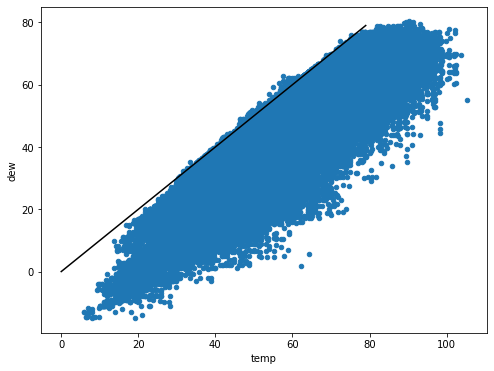

In [164]:
ax=w2.plot.scatter('temp','dew')
ax.plot(list(range(80)),list(range(80)),'k')

In [165]:
# https://iridl.ldeo.columbia.edu/dochelp/QA/Basic/dewpoint.html

In [166]:
w3=w2.copy()
w3.datetime = pd.to_datetime(w2.datetime)

In [167]:
F2K = lambda x: ((x-32)*(5/9)+273.15)   # fahrenheit to kelvin
T_LRv = 5423 # Kelvin
w3['calc_RH'] = 100*np.exp(-T_LRv*((1./F2K(w3.dew))-(1./F2K(w3.temp))))   # percent RH

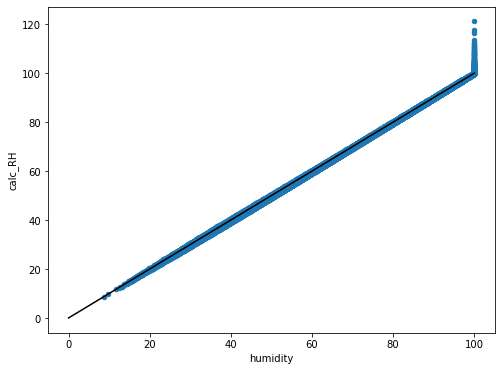

In [168]:
ax=w3.plot.scatter('humidity','calc_RH')
ax.plot(list(range(101)),list(range(101)),'k')

In [169]:
print(sum(w3.calc_RH>100))
w3.sort_values('calc_RH',ascending=False).head(10)

153


datetime  temp   dew  humidity  heatindex  wspd  wgust  \
64126 2018-01-12 21:00:00  57.6  62.9     100.0        NaN   8.6   11.4   
64846 2018-02-11 21:00:00  55.0  59.4     100.0        NaN   5.5    4.7   
28160 2013-12-06 07:00:00  56.5  60.7     100.0        NaN  16.6   29.1   
64848 2018-02-11 23:00:00  57.6  61.1     100.0        NaN   8.0    9.2   
81324 2019-12-30 11:00:00  58.9  62.1     100.0        NaN  13.3   18.3   
64840 2018-02-11 15:00:00  59.0  62.2     100.0        NaN   8.4   11.4   
64956 2018-02-16 11:00:00  54.0  57.0     100.0        NaN   6.7    5.8   
64841 2018-02-11 16:00:00  59.0  62.0     100.0        NaN   7.0    6.9   
64119 2018-01-12 14:00:00  58.5  61.3     100.0        NaN  11.0   13.9   
82252 2020-02-07 03:00:00  51.4  54.1     100.0        NaN   1.9    NaN   

        wdir  windchill  precip  snowdepth  visibility  cloudcover  \
64126  197.0        NaN    0.06        NaN         9.9        23.0   
64846  183.0        NaN    0.00        NaN         6.5        20.2   
28160  330.0        NaN    0.00        NaN         5.0        23.5   
64848  194.0        NaN    0.00        NaN         9.9        21.2   
81324  328.0        NaN    0.00        NaN         9.9        11.8   
64840  200.0        NaN    0.00        NaN         9.9        21.6   
64956  173.0        NaN    0.00        NaN         9.9        20.7   
64841  192.0        NaN    0.00        NaN         9.9        21.2   
64119  188.0        NaN    0.00        NaN         9.9        23.0   
82252  190.0        NaN    0.00        NaN         9.9        23.5   

       sealevelpressure  moonphase   rain  overcast  partially_cloudy  \
64126            1001.3       0.93   True     False             False   
64846            1013.2       0.93  False     False             False   
28160            1013.9       0.08  False     False             False   
64848            1014.1       0.94  False     False             False   
81324            1002.7       0.09  False     False             False   
64840            1011.2       0.93  False     False             False   
64956            1006.9       0.00  False     False             False   
64841            1011.1       0.93  False     False             False   
64119            1006.2       0.92  False     False             False   
82252             988.5       0.47  False     False             False   

          calc_RH  
64126  121.093534  
64846  117.441699  
28160  116.490064  
64848  113.522233  
81324  112.237292  
64840  112.232312  
64956  111.665850  
64841  111.430365  
64119  110.655070  
82252  110.558574

In [170]:
pd.concat([w3[~w3.heatindex.isnull()].describe().temp,w3[w3.heatindex.isnull()].describe().temp],axis=1)
# Heat index is only computed for temperatures above 80 F

temp          temp
count  11725.000000  78420.000000
mean      85.271309     55.409324
std        4.159056     15.487759
min       80.000000      6.000000
25%       82.000000     43.000000
50%       84.200000     55.750000
75%       87.900000     69.500000
max      105.300000     80.000000

In [171]:
# Similarly, heat index is a calculation based only on air temperature and water vapor, not an independent measurement:
# https://www.wpc.ncep.noaa.gov/html/heatindex_equation.shtml

In [172]:
# Same thing for wind chill
# https://www.weather.gov/oun/safety-winter-windchill

In [173]:
# We will discard all three calculated columns (humidity, heatindex, windchill)

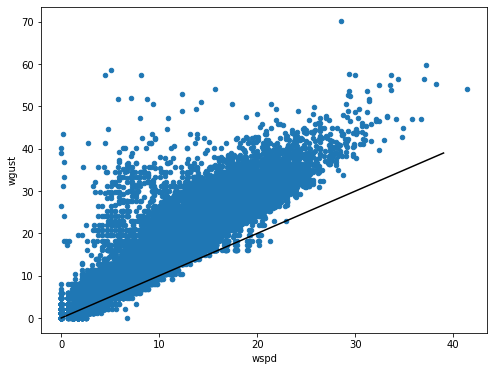

In [174]:
ax=w2.plot.scatter('wspd','wgust')
ax.plot(list(range(40)),list(range(40)),'k')

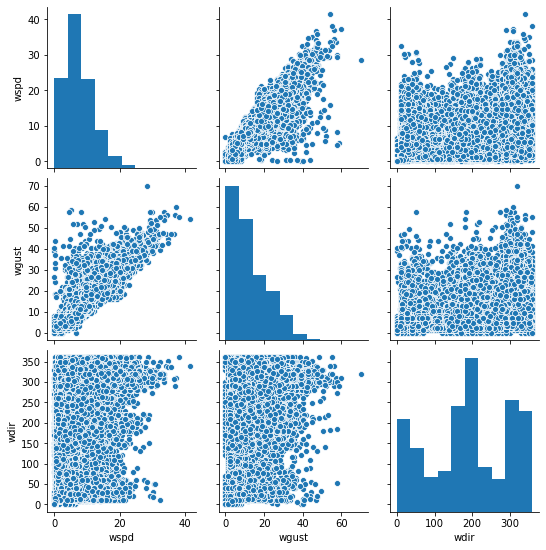

In [175]:
sns.pairplot(w3[['wspd','wgust','wdir']])

In [176]:
# convert wspd,wdir to x and y velocities
w3['wspd_x'] = w3.wspd*(-np.sin(w3.wdir * np.pi/180))
w3['wspd_y'] = w3.wspd*(-np.cos(w3.wdir * np.pi/180))

In [177]:
xx = 180
-np.cos(xx * np.pi/180)

1.0

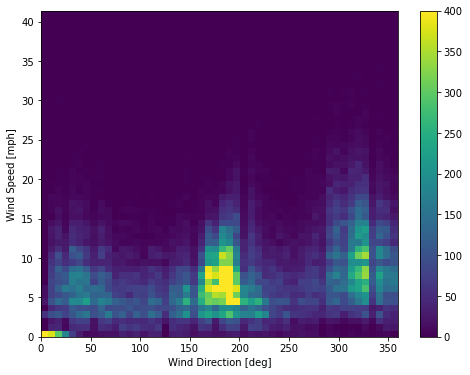

In [178]:
plt.hist2d(w3.wdir[~w3.wdir.isnull()],w3.wspd[~w3.wdir.isnull()], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Speed [mph]')
plt.show()

In [179]:
# 180 === south wind (from visualcrossing documentation)
# ?

In [180]:
w2[w2.datetime.str.contains('2012-06-')].tail(40)
# 2012 derecho ?

datetime   temp   dew  humidity  heatindex  wspd  wgust  \
15560  2012-06-29 08:00:00   82.1  64.8     55.87       83.9   4.4    NaN   
15561  2012-06-29 09:00:00   84.6  66.4     54.53       87.1   6.6    NaN   
15562  2012-06-29 10:00:00   96.3  68.0     39.93      101.4  12.6   19.5   
15563  2012-06-29 11:00:00   96.8  69.5     41.34      103.3  11.1    NaN   
15564  2012-06-29 12:00:00   98.2  69.8     40.05      105.3  10.0    NaN   
15565  2012-06-29 13:00:00  100.1  69.6     37.50      107.6   7.8    NaN   
15566  2012-06-29 14:00:00  101.9  69.2     35.05      109.5   9.0   16.1   
15567  2012-06-29 15:00:00  102.3  69.6     35.11      110.4   6.9    NaN   
15568  2012-06-29 16:00:00  102.4  69.9     35.51      110.8   6.0   16.1   
15569  2012-06-29 17:00:00  103.8  69.5     33.43      112.2   8.2   16.1   
15570  2012-06-29 18:00:00  102.4  66.2     31.20      107.4   6.9    NaN   
15571  2012-06-29 19:00:00   96.7  73.1     46.87      106.9   7.6    NaN   
15572  2012-06-29 20:00:00   98.3  71.5     42.28      107.2   9.7    NaN   
15573  2012-06-29 21:00:00   93.4  73.2     52.21      102.9   8.0    NaN   
15574  2012-06-29 22:00:00   91.2  75.0     59.25      102.2   6.9    NaN   
15575  2012-06-29 23:00:00   75.1  69.5     82.88        NaN  28.5   70.1   
15576  2012-06-30 00:00:00   73.2  69.4     88.13        NaN   7.1   51.9   
15577  2012-06-30 01:00:00   73.2  69.5     88.24        NaN   9.0    NaN   
15578  2012-06-30 02:00:00   73.2  69.5     88.24        NaN   0.2    NaN   
15579  2012-06-30 03:00:00   73.6  69.5     87.06        NaN   0.2    NaN   
15580  2012-06-30 04:00:00   71.7  69.5     92.79        NaN   0.2    NaN   
15581  2012-06-30 05:00:00   73.2  69.4     88.02        NaN   7.1    NaN   
15582  2012-06-30 06:00:00   72.9  67.0     81.71        NaN   7.9    NaN   
15583  2012-06-30 07:00:00   74.7  66.2     74.91        NaN   7.5    NaN   
15584  2012-06-30 08:00:00   78.0  66.2     67.14        NaN   7.4    NaN   
15585  2012-06-30 09:00:00   80.6  67.2     63.89       83.0   5.0    NaN   
15586  2012-06-30 10:00:00   84.4  66.2     54.44       86.7   6.3    NaN   
15587  2012-06-30 11:00:00   86.7  65.0     48.47       88.5   9.3    NaN   
15588  2012-06-30 12:00:00   89.3  64.9     44.65       91.2   7.9    NaN   
15589  2012-06-30 13:00:00   91.7  63.9     39.92       93.2   4.9    NaN   
15590  2012-06-30 14:00:00   93.4  62.3     35.80       94.3   9.8    NaN   
15591  2012-06-30 15:00:00   94.8  59.4     30.83       94.5  10.2    NaN   
15592  2012-06-30 16:00:00   96.3  59.2     29.37       96.0   7.0    NaN   
15593  2012-06-30 17:00:00   94.9  61.0     32.63       95.3   5.8    NaN   
15594  2012-06-30 18:00:00   94.9  62.3     34.20       96.0   0.1    NaN   
15595  2012-06-30 19:00:00   91.6  66.4     43.78       94.6  10.2    NaN   
15596  2012-06-30 20:00:00   89.8  69.9     52.15       95.1   6.6    NaN   
15597  2012-06-30 21:00:00   89.1  69.5     52.58       93.9   6.8    NaN   
15598  2012-06-30 22:00:00   85.8  71.2     61.74       91.4   6.7    NaN   
15599  2012-06-30 23:00:00   85.8  71.6     62.73       91.6   3.4    NaN   

        wdir  windchill  precip  snowdepth  visibility  cloudcover  \
15560  200.0        NaN    0.00        NaN         9.9        99.5   
15561  170.0        NaN    0.00        NaN         9.9        84.2   
15562  318.0        NaN    0.00        NaN         9.9        85.5   
15563  319.0        NaN    0.00        NaN         9.9        96.0   
15564  321.0        NaN    0.00        NaN         9.9        94.1   
15565   29.0        NaN    0.00        NaN         9.9        47.3   
15566  321.0        NaN    0.00        NaN         9.9        47.3   
15567  260.0        NaN    0.00        NaN         9.9        25.9   
15568  260.0        NaN    0.00        NaN         9.9        26.2   
15569  270.0        NaN    0.00        NaN         8.7        26.2   
15570    NaN        NaN    0.00        NaN         9.9        26.2   
15571  180.0        

In [181]:
w2[w2.datetime.str.contains('2011-08-2[78]')]
# Hurricane Irene

datetime  temp   dew  humidity  heatindex  wspd  wgust  \
8184  2011-08-27 00:00:00  78.8  73.7     84.61        NaN   3.2    NaN   
8185  2011-08-27 01:00:00  78.8  73.7     84.61        NaN   4.6    NaN   
8186  2011-08-27 02:00:00  78.4  73.7     85.66        NaN   6.6    NaN   
8187  2011-08-27 03:00:00  78.4  73.7     85.71        NaN   7.6    NaN   
8188  2011-08-27 04:00:00  78.4  73.7     85.71        NaN   7.9    NaN   
8189  2011-08-27 05:00:00  78.4  73.8     85.94        NaN   8.9    NaN   
8190  2011-08-27 06:00:00  78.4  73.7     85.66        NaN  11.0    NaN   
8191  2011-08-27 07:00:00  78.4  73.3     84.53        NaN  13.4    NaN   
8192  2011-08-27 08:00:00  78.5  73.2     84.02        NaN  13.1   20.8   
8193  2011-08-27 09:00:00  78.9  73.2     82.91        NaN  10.1    NaN   
8194  2011-08-27 10:00:00  78.9  73.2     82.91        NaN  16.8    NaN   
8195  2011-08-27 11:00:00  78.5  71.8     79.93        NaN  15.7    NaN   
8196  2011-08-27 12:00:00  75.4  71.3     86.97        NaN  16.7   26.4   
8197  2011-08-27 13:00:00  74.9  70.0     84.61        NaN  20.2   31.1   
8198  2011-08-27 14:00:00  74.9  70.0     84.55        NaN  15.7   28.9   
8199  2011-08-27 15:00:00  73.6  69.9     88.26        NaN  19.4   30.8   
8200  2011-08-27 16:00:00  73.1  69.9     89.55        NaN  28.0   36.1   
8201  2011-08-27 17:00:00  73.2  69.5     88.01        NaN  23.3   35.6   
8202  2011-08-27 18:00:00  73.6  70.0     88.38        NaN  30.2   44.0   
8203  2011-08-27 19:00:00  73.6  70.0     88.38        NaN  30.0   43.9   
8204  2011-08-27 20:00:00  73.6  70.0     88.34        NaN  29.2   41.8   
8205  2011-08-27 21:00:00  73.6  70.0     88.34        NaN  30.3   47.2   
8206  2011-08-27 22:00:00  73.2  69.6     88.36        NaN  32.4   46.6   
8207  2011-08-27 23:00:00  73.2  69.6     88.36        NaN  31.6   45.8   
8208  2011-08-28 00:00:00  71.7  69.5     92.81        NaN  34.9   44.8   
8209  2011-08-28 01:00:00  73.0  68.3     85.10        NaN  38.2   55.3   
8210  2011-08-28 02:00:00  71.6  66.5     83.99        NaN  34.4   56.4   
8211  2011-08-28 03:00:00  73.1  68.0     84.08        NaN  34.2   47.0   
8212  2011-08-28 04:00:00  71.7  66.5     83.58        NaN  31.2   48.7   
8213  2011-08-28 05:00:00  71.3  66.4     84.72        NaN  29.0   50.6   
8214  2011-08-28 06:00:00  71.7  66.4     83.57        NaN  21.1   42.1   
8215  2011-08-28 07:00:00  73.1  66.0     78.58        NaN  19.7   33.2   
8216  2011-08-28 08:00:00  71.2  66.4     84.93        NaN  15.3   28.1   
8217  2011-08-28 09:00:00  71.6  66.4     83.78        NaN  17.5   27.8   
8218  2011-08-28 10:00:00  74.9  66.0     73.97        NaN  17.3   30.3   
8219  2011-08-28 11:00:00  78.3  64.2     61.99        NaN  25.4   37.3   
8220  2011-08-28 12:00:00  78.8  62.7     57.93        NaN  16.4   29.6   
8221  2011-08-28 13:00:00  82.5  62.7     51.36       83.5  16.3   32.0   
8222  2011-08-28 14:00:00  84.4  60.9     45.37       84.6  15.2   30.9   
8223  2011-08-28 15:00:00  85.8  60.5     42.54       85.8  17.1   30.5   
8224  2011-08-28 16:00:00  85.8  60.5     42.54       85.8  15.0   27.9   
8225  2011-08-28 17:00:00  87.3  57.6     36.68       86.2  16.1   23.1   
8226  2011-08-28 18:00:00  84.4  57.1     39.55       83.6  12.8   18.3   
8227  2011-08-28 19:00:00  82.6  57.5     42.53       82.3   9.1    NaN   
8228  2011-08-28 20:00:00  80.1  59.1     48.92       80.7   4.6    NaN   
8229  2011-08-28 21:00:00  79.8  57.7     46.84        NaN   4.5    NaN   
8230  2011-08-28 22:00:00  74.8  61.2     62.66        NaN   5.5    NaN   
8231  2011-08-28 23:00:00  73.3  62.8     69.61        NaN   4.4    NaN   

       wdir  windchill  precip  snowdepth  visibility  cloudcover  \
8184   47.0        NaN    0.00        NaN         9.9        88.9   
8185   10.0        NaN    0.00        NaN         9.9        89.6   
8186   60.0        NaN    0.00        NaN         9.9        89.5   
8187   47.0        NaN    0.00        NaN         9.9       100.0

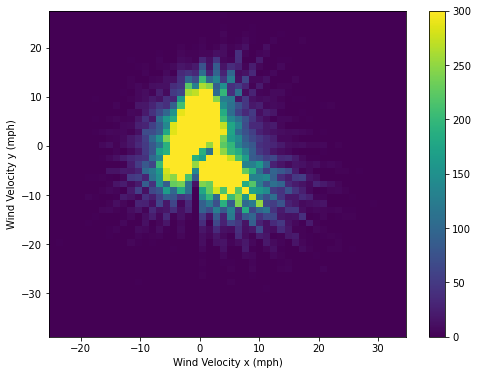

In [182]:
plt.hist2d(w3.wspd_x[~w3.wdir.isnull()],w3.wspd_y[~w3.wdir.isnull()], bins=(50, 50), vmax=300)
plt.colorbar()
plt.xlabel('Wind Velocity x (mph)')
plt.ylabel('Wind Velocity y (mph)')
plt.show()

In [183]:
# Wind Gust:

In [184]:
# has a lot of nulls

In [185]:
w3.describe()

temp           dew      humidity     heatindex          wspd  \
count  90145.000000  90144.000000  90144.000000  11725.000000  90144.000000   
mean      59.293419     45.735093     63.471249     88.554891      7.495993   
std       17.658489     19.052064     18.977735      5.888494      4.702135   
min        6.000000    -14.900000      8.660000     78.700000      0.000000   
25%       44.800000     30.400000     48.320000     84.100000      4.400000   
50%       60.100000     47.900000     63.550000     87.300000      6.900000   
75%       74.100000     62.600000     79.420000     92.000000     10.100000   
max      105.300000     80.300000    100.000000    120.800000     41.400000   

              wgust          wdir     windchill        precip   snowdepth  \
count  41099.000000  89756.000000  25916.000000  90145.000000  397.000000   
mean      12.717429    189.129763     33.352477      0.004609   32.414937   
std        9.116649    106.564254      9.962976      0.033815   63.428585   
min        0.000000      0.000000    -12.000000      0.000000    0.000000   
25%        5.800000    110.000000     27.900000      0.000000    1.970000   
50%       10.300000    189.000000     34.900000      0.000000    3.150000   
75%       18.300000    296.000000     41.100000      0.000000   11.020000   
max       70.100000    360.000000     49.500000      2.570000  231.890000   

         visibility    cloudcover  sealevelpressure     moonphase  \
count  90142.000000  90145.000000      90070.000000  90145.000000   
mean       9.398064     47.792757       1017.701964      0.501813   
std        1.611046     33.869588          7.374722      0.307164   
min        0.000000      0.000000        969.500000      0.000000   
25%        9.900000     21.000000       1013.000000      0.250000   
50%        9.900000     36.500000       1017.500000      0.500000   
75%        9.900000     85.300000       1022.300000      0.750000   
max        9.900000    100.000000       1045.700000      1.000000   

            calc_RH        wspd_x        wspd_y  
count  90144.000000  89756.000000  89756.000000  
mean      63.189579      1.316388     -0.060951  
std       19.034505      5.149012      7.097508  
min        8.645083    -25.300000    -38.903275  
25%       47.974499     -1.708952     -5.209102  
50%       63.156114      0.581434     -0.000000  
75%       79.119549      4.120305      5.192874  
max      121.093534     34.768627     27.556505

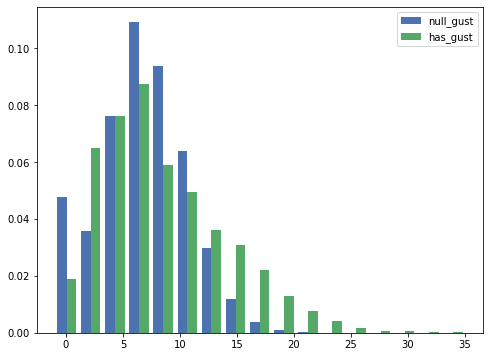

In [186]:
plt.style.use('seaborn-deep')

null_gust = w3.wgust.isnull()
bins = np.linspace(-1, 35, 18)

plt.hist([w3.wspd[null_gust], w3.wspd[~null_gust]], bins, label=['null_gust', 'has_gust'], density=True)
plt.legend(loc='upper right')
plt.show()


In [187]:
# I'll ignore wgust.

# What about filling in null directions?

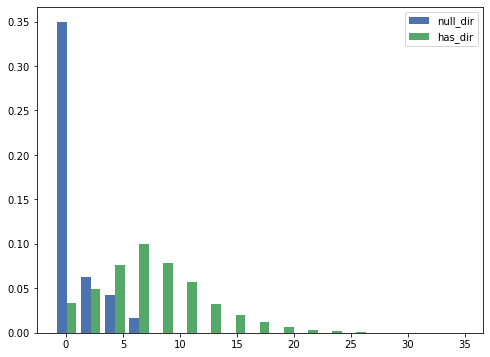

In [188]:
plt.style.use('seaborn-deep')

null_dir = w3.wdir.isnull()
bins = np.linspace(-1, 35, 18)

plt.hist([w3.wspd[null_dir], w3.wspd[~null_dir]], bins, label=['null_dir', 'has_dir'], density=True)
plt.legend(loc='upper right')
plt.show()


In [189]:
# Of the 400 observations w/o a wind direction,
# the vast majority of them have windspeed near zero.
# Let's just set wspd_x=wspd_y=0 for these rows
wind_nulls = (w3.wspd_x.isnull()) | (w3.wspd_y.isnull())
w3.wspd_x[wind_nulls]=0
w3.wspd_y[wind_nulls]=0

C:\Users\rek\Anaconda3\envs\ai\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\rek\Anaconda3\envs\ai\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


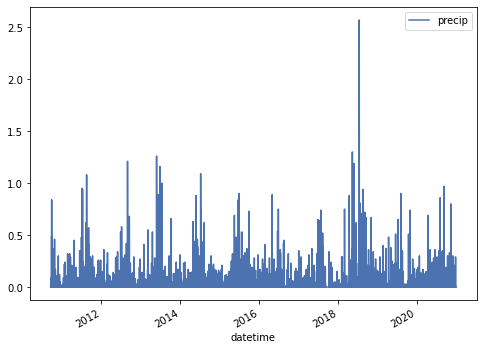

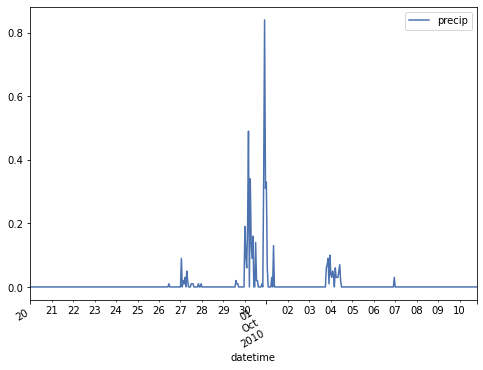

In [190]:
# Precipitation:
plot_cols = ['precip']
plot_features = w3[plot_cols]
plot_features.index = w3.datetime
_ = plot_features.plot(subplots=True)
plot_features = w3[plot_cols][:500]
plot_features.index = w3.datetime[:500]
_ = plot_features.plot(subplots=True)

In [191]:
# precip looks okay

In [192]:
# snowdepth has some problems though

# 1) Almost all entries all null. Should these be zeros instead?
# 2) also some extremely anomalous measurements (in inches!)

In [193]:
w3.describe()

temp           dew      humidity     heatindex          wspd  \
count  90145.000000  90144.000000  90144.000000  11725.000000  90144.000000   
mean      59.293419     45.735093     63.471249     88.554891      7.495993   
std       17.658489     19.052064     18.977735      5.888494      4.702135   
min        6.000000    -14.900000      8.660000     78.700000      0.000000   
25%       44.800000     30.400000     48.320000     84.100000      4.400000   
50%       60.100000     47.900000     63.550000     87.300000      6.900000   
75%       74.100000     62.600000     79.420000     92.000000     10.100000   
max      105.300000     80.300000    100.000000    120.800000     41.400000   

              wgust          wdir     windchill        precip   snowdepth  \
count  41099.000000  89756.000000  25916.000000  90145.000000  397.000000   
mean      12.717429    189.129763     33.352477      0.004609   32.414937   
std        9.116649    106.564254      9.962976      0.033815   63.428585   
min        0.000000      0.000000    -12.000000      0.000000    0.000000   
25%        5.800000    110.000000     27.900000      0.000000    1.970000   
50%       10.300000    189.000000     34.900000      0.000000    3.150000   
75%       18.300000    296.000000     41.100000      0.000000   11.020000   
max       70.100000    360.000000     49.500000      2.570000  231.890000   

         visibility    cloudcover  sealevelpressure     moonphase  \
count  90142.000000  90145.000000      90070.000000  90145.000000   
mean       9.398064     47.792757       1017.701964      0.501813   
std        1.611046     33.869588          7.374722      0.307164   
min        0.000000      0.000000        969.500000      0.000000   
25%        9.900000     21.000000       1013.000000      0.250000   
50%        9.900000     36.500000       1017.500000      0.500000   
75%        9.900000     85.300000       1022.300000      0.750000   
max        9.900000    100.000000       1045.700000      1.000000   

            calc_RH        wspd_x        wspd_y  
count  90144.000000  90145.000000  90145.000000  
mean      63.189579      1.310708     -0.060688  
std       19.034505      5.138615      7.082178  
min        8.645083    -25.300000    -38.903275  
25%       47.974499     -1.693453     -5.200352  
50%       63.156114      0.555674     -0.000000  
75%       79.119549      4.088480      5.168309  
max      121.093534     34.768627     27.556505

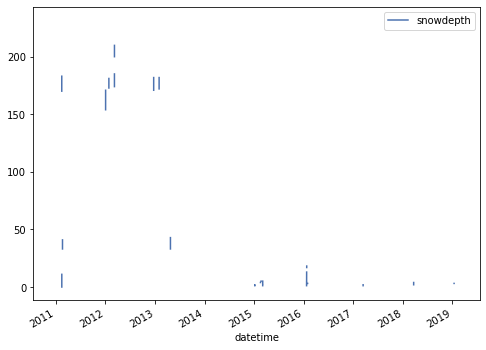

In [194]:
# snowdepth is a problem, though, mostly nulls
plot_cols = ['snowdepth']
plot_features = w3[plot_cols]
plot_features.index = w3.datetime
_ = plot_features.plot(subplots=True)

In [195]:
# Good:
    # Isolated clusters, and these seem to occur at the correct time of each year.
    # In fact, 2020 has no measurements at all, consistent with my recollection
    
# Bad:
    # Units??? Supposed to be inches. Many values are way too high.
    # Measurements, when they do exist, are often spaced out every 6 hours
        # hours 01 07 13 19
        # requires interpolation

In [196]:
w3[~w3.snowdepth.isnull()].tail()
# No snowdepth measurements in all of 2020 !

datetime  temp   dew  humidity  heatindex  wspd  wgust  \
73814 2019-02-20 13:00:00  31.7  28.1     86.54        NaN   5.5    8.1   
73820 2019-02-20 19:00:00  33.2  30.8     91.06        NaN   3.1    2.2   
73826 2019-02-21 01:00:00  34.1  32.0     91.93        NaN   1.4    3.4   
73832 2019-02-21 07:00:00  34.8  32.0     89.51        NaN   1.2    2.2   
73838 2019-02-21 13:00:00  45.0  38.0     76.45        NaN   3.4    4.7   

        wdir  windchill  precip  snowdepth  visibility  cloudcover  \
73814  120.0       26.3    0.14       3.15         3.1        34.1   
73820  138.0       30.4    0.00       1.55         9.9        34.1   
73826  206.0        NaN    0.00       1.97         8.1        36.5   
73832  250.0        NaN    0.00       1.97         8.7        21.8   
73838  163.0       43.7    0.00       1.18         9.9        36.5   

       sealevelpressure  moonphase   rain  overcast  partially_cloudy  \
73814            1030.0       0.51   True     False              True   
73820            1024.9       0.52  False     False              True   
73826            1017.0       0.52  False     False              True   
73832            1016.4       0.53  False     False             False   
73838            1017.7       0.53  False     False              True   

         calc_RH    wspd_x    wspd_y  
73814  86.362277 -4.763140  2.750000  
73820  90.763568 -2.074305  2.303749  
73826  91.902952  0.613720  1.258312  
73832  89.366585  1.127631  0.410424  
73838  76.181022 -0.994064  3.251436

In [197]:
w3.groupby(w3.datetime.dt.year).snowdepth.max()

datetime
2010      1.97
2011    231.89
2012    214.17
2013    231.10
2014    225.20
2015      5.20
2016     18.22
2017      1.97
2018      3.94
2019      9.84
2020       NaN
Name: snowdepth, dtype: float64

In [198]:
w3[~w3.snowdepth.isnull()][['datetime','temp','snowdepth']]

datetime  temp  snowdepth
2102  2010-12-16 13:00:00  23.4       1.18
2108  2010-12-16 19:00:00  26.5       1.97
2114  2010-12-17 01:00:00  23.7       1.97
2120  2010-12-17 07:00:00  27.4       1.18
2126  2010-12-17 13:00:00  37.6       1.18
2738  2011-01-12 01:00:00  30.1       1.18
2744  2011-01-12 07:00:00  28.6       1.18
3092  2011-01-26 19:00:00  33.4       1.97
3098  2011-01-27 01:00:00  35.7       5.12
3104  2011-01-27 07:00:00  33.5       3.94
3110  2011-01-27 13:00:00  35.7       3.94
3116  2011-01-27 19:00:00  33.6       3.94
3122  2011-01-28 01:00:00  33.4       3.94
3128  2011-01-28 07:00:00  30.5       3.94
3134  2011-01-28 13:00:00  34.4       4.57
3140  2011-01-28 19:00:00  37.1       3.94
3146  2011-01-29 01:00:00  35.3       3.94
3152  2011-01-29 07:00:00  30.0       3.94
3158  2011-01-29 13:00:00  35.3       3.15
3164  2011-01-29 19:00:00  35.7       3.15
3170  2011-01-30 01:00:00  28.5       3.15
3176  2011-01-30 07:00:00  28.4       3.15
3182  2011-01-30 13:00:00  40.9       3.15
3188  2011-01-30 19:00:00  38.8       1.97
3194  2011-01-31 01:00:00  35.5       1.97
3200  2011-01-31 07:00:00  30.0       1.97
3206  2011-01-31 13:00:00  30.4       1.97
3212  2011-01-31 19:00:00  30.0       1.97
3218  2011-02-01 01:00:00  30.0       1.97
3224  2011-02-01 07:00:00  30.1       1.97
3230  2011-02-01 13:00:00  35.2       1.97
3236  2011-02-01 19:00:00  37.1       1.97
3242  2011-02-02 01:00:00  35.2       1.18
3248  2011-02-02 07:00:00  35.6       1.18
3542  2011-02-14 13:00:00  68.0     170.08
3543  2011-02-14 14:00:00  69.8     183.07
3549  2011-02-14 20:00:00  48.5       0.00
3550  2011-02-14 21:00:00  48.4      11.02
3553  2011-02-15 00:00:00  42.9      42.91
3649  2011-02-19 00:00:00  58.9      44.09
3652  2011-02-19 03:00:00  53.3      72.05
3655  2011-02-19 06:00:00  51.4     103.94
3667  2011-02-19 18:00:00  48.4     224.02
3672  2011-02-19 23:00:00  40.9      33.07
3673  2011-02-20 00:00:00  39.0      40.94
3803  2011-02-25 10:00:00  53.4     142.91
3812  2011-02-25 19:00:00  42.9     229.92
5276  2011-04-27 20:00:00  71.8     231.89
5291  2011-04-28 11:00:00  71.4     135.04
6883  2011-07-03 19:00:00  73.5     225.20
7120  2011-07-13 16:00:00  73.8     190.16
8207  2011-08-27 23:00:00  73.2      20.08
8219  2011-08-28 11:00:00  78.3     142.33
9667  2011-10-27 19:00:00  59.0     224.02
10309 2011-11-23 12:00:00  59.1     164.17
11292 2012-01-03 11:00:00  31.8     153.94
11293 2012-01-03 12:00:00  32.0     162.99
11294 2012-01-03 13:00:00  31.9     170.87
11296 2012-01-03 15:00:00  28.8     190.16
11531 2012-01-13 10:00:00  37.1     135.04
11534 2012-01-13 13:00:00  39.4     172.05
11646 2012-01-18 05:00:00  46.1      92.13
11714 2012-01-21 01:00:00  28.2       1.18
11720 2012-01-21 07:00:00  30.4       1.18
11870 2012-01-27 13:00:00  60.5     172.83
11871 2012-01-27 14:00:00  59.1     181.10
11873 2012-01-27 16:00:00  53.3     203.94
11929 2012-01-30 00:00:00  38.9      35.04
12234 2012-02-11 17:00:00  35.6     214.17
12563 2012-02-25 10:00:00  42.4     144.09
12567 2012-02-25 14:00:00  44.7     183.07
12854 2012-03-08 13:00:00  71.7     174.02
12855 2012-03-08 14:00:00  73.3     185.04
12857 2012-03-08 16:00:00  71.7     200.00
12858 2012-03-08 17:00:00  71.2     209.84
13285 2012-03-26 13:00:00  59.1     164.96
13289 2012-03-26 17:00:00  57.5     201.18
13622 2012-04-09 14:00:00  66.4     170.87
15576 2012-06-30 00:00:00  73.2      24.80
17507 2012-09-18 11:00:00  78.5     144.09
17510 2012-09-18 14:00:00  78.8     172.83
18493 2012-10-29 13:00:00  51.4     162.99
19107 2012-11-24 02:00:00  44.2      62.99
19779 2012-12-22 02:00:00  39.5      61.81
19785 2012-12-22 08:00:00  39.4     122.83
19787 2012-12-22 10:00:00  39.4     142.91
19790 2012-12-22 13:00:00  44.7     170.87
19791 2012-12-22 14:00:00  44.7     181.89
19909 2012-12-27 12:00:00  42.3     161.81
19966 2012-12-29 21:00:00  40.9      14.17
19983 2012-12-30 14:00:00  42.3     183.07
20522 2013-01-22 01:00:00  30.9      51.97
20743 2013-01-31 0

In [199]:
# Need to fill in missing values when measurements are in 6h intervals

# The highest numbers often occur out of season, and also at unreasonably warm temperatures

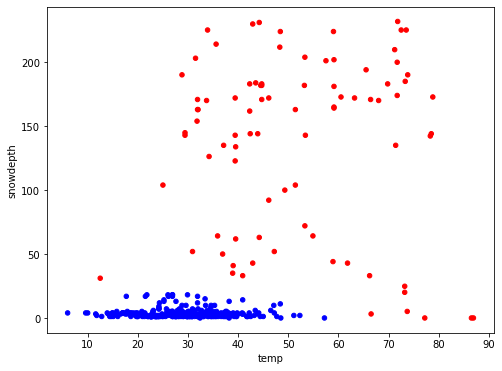

In [200]:
valid_snowdepth = (w3.snowdepth<30) & ((w3.datetime.dt.month<4) | (w3.datetime.dt.month>10))
w3.plot.scatter('temp','snowdepth',c=valid_snowdepth.map({True:'b',False:'r'}))

#w3[(w3.snowdepth<18)]

In [201]:
# Strategy:
    # Write NaN to the red points
    # Backfill all Nans to close the 6h gaps (we'll backfill up to 12h)
                    # actually 12 entries, not hours...
    # anything longer than 12 hours without a measurement becomes zero
    
    # 2014-02-15: example of a situation where this strategy is designed to work

In [202]:
w3.snowdepth[~valid_snowdepth]=np.nan
w3.snowdepth.ffill(limit=3,inplace=True)
w3.snowdepth.fillna(value=0.0,inplace=True)

C:\Users\rek\Anaconda3\envs\ai\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [203]:
# example: ffill and fillna:
ps=pd.Series([6,23,np.nan,43,np.nan,np.nan,np.nan,np.nan,1])
pd.concat([ps,\
           ps.ffill(limit=1),\
           ps.ffill(limit=2),\
           ps.ffill(limit=2).fillna(value=0)],axis=1)

0     1     2     3
0   6.0   6.0   6.0   6.0
1  23.0  23.0  23.0  23.0
2   NaN  23.0  23.0  23.0
3  43.0  43.0  43.0  43.0
4   NaN  43.0  43.0  43.0
5   NaN   NaN  43.0  43.0
6   NaN   NaN   NaN   0.0
7   NaN   NaN   NaN   0.0
8   1.0   1.0   1.0   1.0

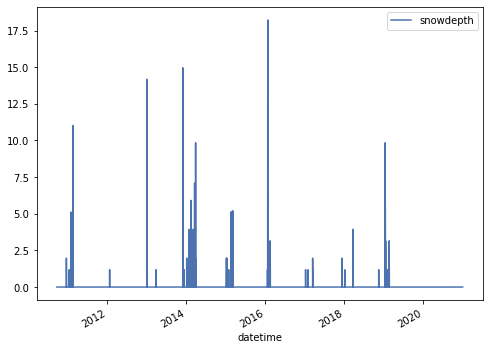

In [204]:
w3.plot('datetime','snowdepth')

In [205]:
w3.describe()

temp           dew      humidity     heatindex          wspd  \
count  90145.000000  90144.000000  90144.000000  11725.000000  90144.000000   
mean      59.293419     45.735093     63.471249     88.554891      7.495993   
std       17.658489     19.052064     18.977735      5.888494      4.702135   
min        6.000000    -14.900000      8.660000     78.700000      0.000000   
25%       44.800000     30.400000     48.320000     84.100000      4.400000   
50%       60.100000     47.900000     63.550000     87.300000      6.900000   
75%       74.100000     62.600000     79.420000     92.000000     10.100000   
max      105.300000     80.300000    100.000000    120.800000     41.400000   

              wgust          wdir     windchill        precip     snowdepth  \
count  41099.000000  89756.000000  25916.000000  90145.000000  90145.000000   
mean      12.717429    189.129763     33.352477      0.004609      0.044072   
std        9.116649    106.564254      9.962976      0.033815      0.545045   
min        0.000000      0.000000    -12.000000      0.000000      0.000000   
25%        5.800000    110.000000     27.900000      0.000000      0.000000   
50%       10.300000    189.000000     34.900000      0.000000      0.000000   
75%       18.300000    296.000000     41.100000      0.000000      0.000000   
max       70.100000    360.000000     49.500000      2.570000     18.220000   

         visibility    cloudcover  sealevelpressure     moonphase  \
count  90142.000000  90145.000000      90070.000000  90145.000000   
mean       9.398064     47.792757       1017.701964      0.501813   
std        1.611046     33.869588          7.374722      0.307164   
min        0.000000      0.000000        969.500000      0.000000   
25%        9.900000     21.000000       1013.000000      0.250000   
50%        9.900000     36.500000       1017.500000      0.500000   
75%        9.900000     85.300000       1022.300000      0.750000   
max        9.900000    100.000000       1045.700000      1.000000   

            calc_RH        wspd_x        wspd_y  
count  90144.000000  90145.000000  90145.000000  
mean      63.189579      1.310708     -0.060688  
std       19.034505      5.138615      7.082178  
min        8.645083    -25.300000    -38.903275  
25%       47.974499     -1.693453     -5.200352  
50%       63.156114      0.555674     -0.000000  
75%       79.119549      4.088480      5.168309  
max      121.093534     34.768627     27.556505

In [206]:
# w4
    # 1) reindex for timestamps corresponding to bikeshare data
    # 2) downselect to the columns we want to keep

In [207]:
ydh_2_datetime = lambda T: datetime.datetime(T[0],1,1,T[2]) + datetime.timedelta(int(T[1]-1))

In [208]:
ps_datetime = pd.Series([ydh_2_datetime(tuple(tup)) for tup in ydhw])
ps_datetime.index = ps_datetime

In [209]:
cols_w = ['temp','dew','wspd_x','wspd_y','precip','snowdepth']

In [210]:
w4 = w3.set_index('datetime',drop=False)\
        .drop_duplicates(subset='datetime',keep='first')\
        .reindex(ps_datetime.index)
w4=w4[['datetime']+cols_w]
# set_index(verify_integrity=True) throws error at Fallbacks but offers no fix

In [211]:
w4.datetime = w4.index # fills interpolated hour into spring forward rows, datetime column
w4.iloc[82955:82962]

datetime  temp   dew    wspd_x    wspd_y  \
2020-03-07 22:00:00 2020-03-07 22:00:00  45.1  18.0  4.349611 -5.986726   
2020-03-07 23:00:00 2020-03-07 23:00:00  44.0  17.1  4.499513 -5.362311   
2020-03-08 00:00:00 2020-03-08 00:00:00  43.4  19.1  6.106482 -7.277422   
2020-03-08 01:00:00 2020-03-08 01:00:00  42.4  20.0  5.610850 -5.418335   
2020-03-08 02:00:00 2020-03-08 02:00:00   NaN   NaN       NaN       NaN   
2020-03-08 03:00:00 2020-03-08 03:00:00  40.1  20.0  3.985826 -2.490621   
2020-03-08 04:00:00 2020-03-08 04:00:00  40.1  20.0  0.648751  3.337532   

                     precip  snowdepth  
2020-03-07 22:00:00     0.0        0.0  
2020-03-07 23:00:00     0.0        0.0  
2020-03-08 00:00:00     0.0        0.0  
2020-03-08 01:00:00     0.0        0.0  
2020-03-08 02:00:00     NaN        NaN  
2020-03-08 03:00:00     0.0        0.0  
2020-03-08 04:00:00     0.0        0.0

In [212]:
w4.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 90133 entries, 2010-09-20 11:00:00 to 2020-12-31 23:00:00
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   datetime   90133 non-null  datetime64[ns]
 1   temp       90123 non-null  float64       
 2   dew        90122 non-null  float64       
 3   wspd_x     90123 non-null  float64       
 4   wspd_y     90123 non-null  float64       
 5   precip     90123 non-null  float64       
 6   snowdepth  90123 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 5.5 MB


In [213]:
# SpringForward rows are nulls (plus one missing dewpoint). Fill these:
w4.ffill(limit=2,inplace=True)

In [214]:
w4.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 90133 entries, 2010-09-20 11:00:00 to 2020-12-31 23:00:00
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   datetime   90133 non-null  datetime64[ns]
 1   temp       90133 non-null  float64       
 2   dew        90133 non-null  float64       
 3   wspd_x     90133 non-null  float64       
 4   wspd_y     90133 non-null  float64       
 5   precip     90133 non-null  float64       
 6   snowdepth  90133 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 5.5 MB


In [215]:
w4

datetime  temp   dew    wspd_x    wspd_y  \
2010-09-20 11:00:00 2010-09-20 11:00:00  71.7  42.9 -6.156002  6.836932   
2010-09-20 12:00:00 2010-09-20 12:00:00  73.6  42.5 -5.466403  7.523858   
2010-09-20 13:00:00 2010-09-20 13:00:00  74.9  39.4  1.133385 -9.230679   
2010-09-20 14:00:00 2010-09-20 14:00:00  76.0  39.0  3.868238 -9.112998   
2010-09-20 15:00:00 2010-09-20 15:00:00  77.4  35.7  0.620833 -8.878320   
...                                 ...   ...   ...       ...       ...   
2020-12-31 19:00:00 2020-12-31 19:00:00  43.3  32.0 -2.761738 -5.662402   
2020-12-31 20:00:00 2020-12-31 20:00:00  42.6  33.2 -3.156272 -6.471317   
2020-12-31 21:00:00 2020-12-31 21:00:00  42.7  30.8  8.787798  5.927445   
2020-12-31 22:00:00 2020-12-31 22:00:00  41.6  29.0  6.540489  5.109990   
2020-12-31 23:00:00 2020-12-31 23:00:00  41.8  29.0 -1.911183 -7.665336   

                     precip  snowdepth  
2010-09-20 11:00:00     0.0        0.0  
2010-09-20 12:00:00     0.0        0.0  
2010-09-20 13:00:00     0.0        0.0  
2010-09-20 14:00:00     0.0        0.0  
2010-09-20 15:00:00     0.0        0.0  
...                     ...        ...  
2020-12-31 19:00:00     0.0        0.0  
2020-12-31 20:00:00     0.0        0.0  
2020-12-31 21:00:00     0.0        0.0  
2020-12-31 22:00:00     0.0        0.0  
2020-12-31 23:00:00     0.0        0.0  

[90133 rows x 7 columns]

# Output everything to DB

In [216]:
d_staidx2term = {d_term2staidx[k]:k for k in d_term2staidx}

In [217]:
df_bike = pd.DataFrame(bike,index=w4.index,columns=list(pd.RangeIndex(618).map(d_staidx2term)))\
                .reset_index().rename(columns={'index':'datetime'})
df_dock = pd.DataFrame(dock,index=w4.index,columns=list(pd.RangeIndex(618).map(d_staidx2term)))\
                .reset_index().rename(columns={'index':'datetime'})

In [218]:
# Store all data for modeling in DB:
db_out = 'cabi_data_for_TF_2.db'

tic=time.time()
conn = sqlite3.connect(db_out)
df_bike.to_sql('bike',conn,if_exists='replace',index=False)
df_dock.to_sql('dock',conn,if_exists='replace',index=False)
w4.to_sql('weather',conn,if_exists='replace',index=False)
conn.close()
print(time.time()-tic)

18.922976970672607


In [219]:
assert 2==3

AssertionError: 

# Backup: Other Experiments/Analyses

In [ ]:
# Tensorflow Loss Functions

In [ ]:
y_true = [[1., 1.], [0., 0.]]
y_pred = [[1., 1.], [0., 0.]]
# Using 'auto'/'sum_over_batch_size' reduction type.
p = tf.keras.losses.Poisson()
p(y_true, y_pred).numpy()

In [ ]:
y_true = [40000000.]
y_pred = [10.]
# Using 'auto'/'sum_over_batch_size' reduction type.
p = tf.keras.losses.MeanSquaredError()
p(y_true, y_pred).numpy()

In [ ]:
num_timesteps = 30
observed_counts = np.round(3 + np.random.lognormal(np.log(np.linspace(
    num_timesteps, 5, num=num_timesteps)), 0.20, size=num_timesteps)) 

In [ ]:
(np.linspace(
    num_timesteps, 5, num=num_timesteps))

In [ ]:
np.log(np.linspace(
    num_timesteps, 5, num=num_timesteps))

In [ ]:
np.random.lognormal(np.log(np.linspace(
    num_timesteps, 5, num=num_timesteps)), 0.20, size=num_timesteps)

In [ ]:
np.round(3 + np.random.lognormal(np.log(np.linspace(
    num_timesteps, 5, num=num_timesteps)), 0.20, size=num_timesteps)) 

In [ ]:
import tensorflow as tf
from tensorflow.keras.losses import Loss

class MyHuberLoss(Loss): #inherit parent class
  
    #class attribute
    threshold = 1
  
    #initialize instance attributes
    def __init__(self, threshold):
        super().__init__()
        self.threshold = threshold

    #compute loss
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) <= self.threshold
        small_error_loss = tf.square(error) / 2
        big_error_loss = self.threshold * (tf.abs(error) - (0.5 * self.threshold))
        return tf.where(is_small_error, small_error_loss, big_error_loss)

In [ ]:
n=101
X = np.zeros((n,1))
y = (np.random.rand(n))

In [ ]:
model = tf.keras.Sequential([keras.layers.Dense(units=1, input_shape=[1])])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1), loss='mean_squared_error')

In [ ]:
xs = np.array([-1.0,  0.0, 1.0, 2.0, 3.0, 4.0], dtype=float)
ys = np.array([-3.0, -1.0, 1.0, 3.0, 5.0, 7.0], dtype=float)
model.fit(xs, ys, epochs=500)

In [ ]:
print(model.predict([10.0]))

In [ ]:
model.weights

In [ ]:
n=101
X = np.zeros(n)
j=-1
diff_be = 0
while (diff_be<0.99):
    j+=1
    np.random.seed(j)
    y = (np.random.rand(n))
    diff_be = abs(y[0]-y[-1])
print('seed %d'%j)
print((y[0],y[-1]))
y_swapped = np.concatenate([y[-1:],y[1:-1],y[:1]])
print(np.mean(y),np.mean(y_swapped))

In [ ]:
model = tf.keras.Sequential([keras.layers.Dense(units=1, input_shape=[0])])
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1), loss='mean_squared_error')

In [ ]:
model.fit(np.zeros((n,0)), y, epochs=1000, batch_size=n-1, verbose=1, shuffle=False)

In [ ]:
print(np.sum((y-np.mean(y))**2)/n)

In [ ]:
print(model.weights[1].numpy())
print(np.mean(y))

In [ ]:
y

In [ ]:
# What we do know:
    # IF batch_size >= n, we get results that converge to the mean, as expected
        # Regardless of shuffle (as expected)
    # IF batch_size < n, results appear to converge, but not especially close to the correct answer
        # Now the answer depends upon shuffle
        # result is random if shuffle=True, reproducible otherwise
    # What's going on?
    
    # 

# Tough to figure out what's going on!


In [ ]:
# Let's try:
    # smaller dataset, so we can get every element a turn as the final el
n=5
y = np.array([0.01*j for j in range(n)])

In [ ]:
n=4
runs=20
for _ in range(runs):
    arr = np.array([0.01*j for j in range(n)])
    np.random.shuffle(arr)
    model = tf.keras.Sequential([keras.layers.Dense(units=1, input_shape=[0])])
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1), loss='mean_squared_error')
    model.fit(np.zeros((n,0)), arr, epochs=100, batch_size=2, verbose=0, shuffle=False)
    print((_,arr,model.weights[1].numpy()[0]))

In [ ]:
# Ah okay. It does behave as expected. Result only depends on which value was "held out" of the batch

# What if we have TF do the shuffle rather than numpy?

In [ ]:
runs=200
n=3
y = np.array([0.01*j for j in range(n)])
resultant_biases = []
for _ in range(runs):
    arr = np.array([0.01*j for j in range(n)])
    #np.random.shuffle(arr)
    model = tf.keras.Sequential([keras.layers.Dense(units=1, input_shape=[0])])
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1), loss='mean_squared_error')
    model.fit(np.zeros((n,0)), arr, epochs=100, batch_size=n-1, verbose=0, shuffle=True)
    print((_,arr[-1],model.weights[1].numpy()[0]))
    resultant_biases.append(model.weights[1].numpy()[0])

In [ ]:
print(len(np.array(resultant_biases)))
print(len(np.unique(np.array(resultant_biases))))
# Even with a training set size of only 3, shuffling introduces complete randomness
    # ---> each shuffle at every epoch contributes:
    # with k epochs, presumably there are 3^k paths with 3^k distinct results possible

In [ ]:
# Try only 2 epochs. Won't converge but you should see exactly 9 unique results
runs=200
n=3
y = np.array([0.01*j for j in range(n)])
resultant_biases_9 = []
for _ in range(runs):
    arr = np.array([0.01*j for j in range(n)])
    #np.random.shuffle(arr)
    model = tf.keras.Sequential([keras.layers.Dense(units=1, input_shape=[0])])
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1), loss='mean_squared_error')
    model.fit(np.zeros((n,0)), arr, epochs=2, batch_size=n-1, verbose=0, shuffle=True)
    print((_,arr[-1],model.weights[1].numpy()[0]))
    resultant_biases_9.append(model.weights[1].numpy()[0])
print()
print(len(np.array(resultant_biases_9)))
print(len(np.unique(np.array(resultant_biases_9))))

In [ ]:
print(np.sum((y-np.mean(y))**2)/n)
print(np.sum((y-model.weights[1].numpy()[0])**2)/n)

In [ ]:
np.random.shuffle(np.array([0.01*j for j in range(n)]))

In [ ]:
# Reminder: the entire purpose of this investigation was:
    # figure out a way to test if my custom loss function is implemented correctly
    # upshot:
        # make sure to set batch_size equal to the training_set size !!!!!!!
            # (i.e. full batch gradient descent)
        # with this setting... shuffle doesn't matter and you always get reproducible, predictable results
        # loss function can be compared vs TF output !!!